# * Index
#### 0. 문제의 정의(problem definition) 및 관련 hr이론
#### 1. data 분포 살펴보기
#### 2. our best and most experienced employees에 대한 정의 - GE 9 block
#### 3. Left reason(3_cluster) - PCA분석 및 graph
#### 4. Predict which valuable employees will leave next - cosine similarity
#### 5. 결론 및 추가 논의사항

<br />
<br />
<br />

# 0 . 문제의 정의(problem definition) 및 관련 hr이론 

<br />
###  - 문제의 정의
Kaggle에 있는 문제 소개 중

"Why are our best and most experienced employees leaving prematurely?" 

"Have fun with this database and try to predict which valuable employees will leave next." 
<br />

이 문제의 포인트를 요약해보면,

- 첫번째, **our best and most experienced employees**에 대한 **정의**가 선제되어야 한다.

- 두번째, predict가 핵심 키워드가 아니라 valuable employees will **leave next**이 핵심 키워드이다.

predict를 핵심 키워드로 생각해서 **classification**으로 접근하게 되면, accuracy가 높더라도 **현재 인원**에 대한 분류이다. 

또한 **새로운 data**가 들어왔을 때, 어떤 category에 속하는 가이다.

<br />
하지만 predict which valuable employees will leave next에서 precidt는 hr에서 단순히 **예측**이 아닌, 미리 알아서 이직을 **예방**등과 같은 조치를 취하겠다는 의미이다.

따라서 이직한 인원들의 특징을 파악해서 이와 **현시점에서 이와 유사한 사람**들이 누가있는지 파악해야 한다.
<br />
<br />

### - 관련 hr이론
- **인적자원계획**은 현재 및 장래의 각 시점에서 기업이 필요로 하는 **인원의 수를 예측**하고 이에 대한 사내의 **인력공급을 계획**해서 인력의 수급을 조정하는 계획활동이다.

<br />

- **적정이직률**은 기업이 부담해야 하는 이직비용과 인력보유비용의 합이 최소가 되는, 즉 **이직비용이 최저**가 되는 곳이 존재한다
![image.png](attachment:image.png)

<br />

- **GE-9block**은 GE의 CEO였던 Jack Welch가 **발전가능성(동기부여-x축)**, **결과(성과-y축)**를 사용하여 9가지 block을 구성하고 **상위 10%**는 핵심인재로서 지속적인 **육성**, **하위 10%**는 **방출**하는 인력관리 방법이다.
![9-block.png](attachment:9-block.png)

- 위 그림에서 9,8,6 등과 같이 green 영역에 속한 인재는 **육성**을 하였으며, 7,5,3과 같은 인재는 **유지**를, 4,2과 같은 인재는 **주의**를, 1번과 같은 인재는 **방출**을 하였다.

- 또한 인력 matrix간 인원에서 단기간에는 **한 칸씩 이동**이 가능하다고 가정하여 trainging & develpoment를 시행한다.
    (예를 들어서 9번으로는 8번 6번 영역의 인재들이 이동가능하다고 가정)

<br />
<br />

### - 문제의 정의 및 관련 hr이론을 고려한 앞으로의 전개과정
1. 인적자원계획을 설정하기 위해서 현재 **기업 수요인원과 공급인원**을 살펴본다.
2. 적정이직률과 GE-9block에 의하면 모든 인원이 나가지 않는 것이 좋은 것이 아니다. 때로는 조직에 해가 되는 인원은 조직의 순환을 위해 도움이 된다. 이러한 것을 살펴보기 위해 **GE-9block**으로 인원들을 **segmentaion**해보도록 하겠다.
3. GE-9block으로 나눈 후에는 **이직이 많이 발생하는 집단의 특징**을 살펴본다.
4. 이 특징과 **유사한 현재 인원**을 찾아본다.

<br />
<br />
<br />

# 1. Data의 분포

### import function

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
import matplotlib.pylab as pylab

### import data

In [2]:
df_hr = pd.read_csv("HR_comma_sep.csv")

In [3]:
df_hr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### 데이터 설명
이 데이터는 총 14999의 행과 10개의 열을 가지고 있다. 열의 의미는 아래와 같다.

- Satisfaction Level : 만족수준을 의미하며, 0-1사이의 실수값이다.
- Last evaluation : 최신 평가를 의미하며,0-1사이의 실수값이다.
- Number of projects : 조사를 했을 때, 맡고 있던 프로젝트의 개수를 의미하며 정수값이다.
- Average monthly hours : 월별 평균 근로시간을 의미하며 정수값이다.
- Time spent at the company : 근속년수를 의미하며 정수값이다.
- Whether they have had a work accident : 근무 중 사고를 입었는지 여부(산재여부)(카테고리)
- Whether they have had a promotion in the last 5 years : 최근 5년 간 승진한 적이 있는 지 여부(카테고리)
- Departments (column sales) : 속하는 부서(카테고리)
- Salary : 연봉을 의미하여 high,low, medium으로 카테고리 값이다.
- Whether the employee has left : 퇴사여부를 의미하며 0,1로 이루어진 카테고리 값이다.



### 데이터의 분포의 특징 살펴보기

In [6]:
column_list = [u'satisfaction_level', u'last_evaluation', u'number_project',u'average_montly_hours', u'time_spend_company', u'Work_accident',u'promotion_last_5years', u'sales', u'salary']
categorical=['number_project','time_spend_company','Work_accident','left', 'promotion_last_5years','sales','salary']
not_categorical = [u'satisfaction_level', u'last_evaluation',u'average_montly_hours']

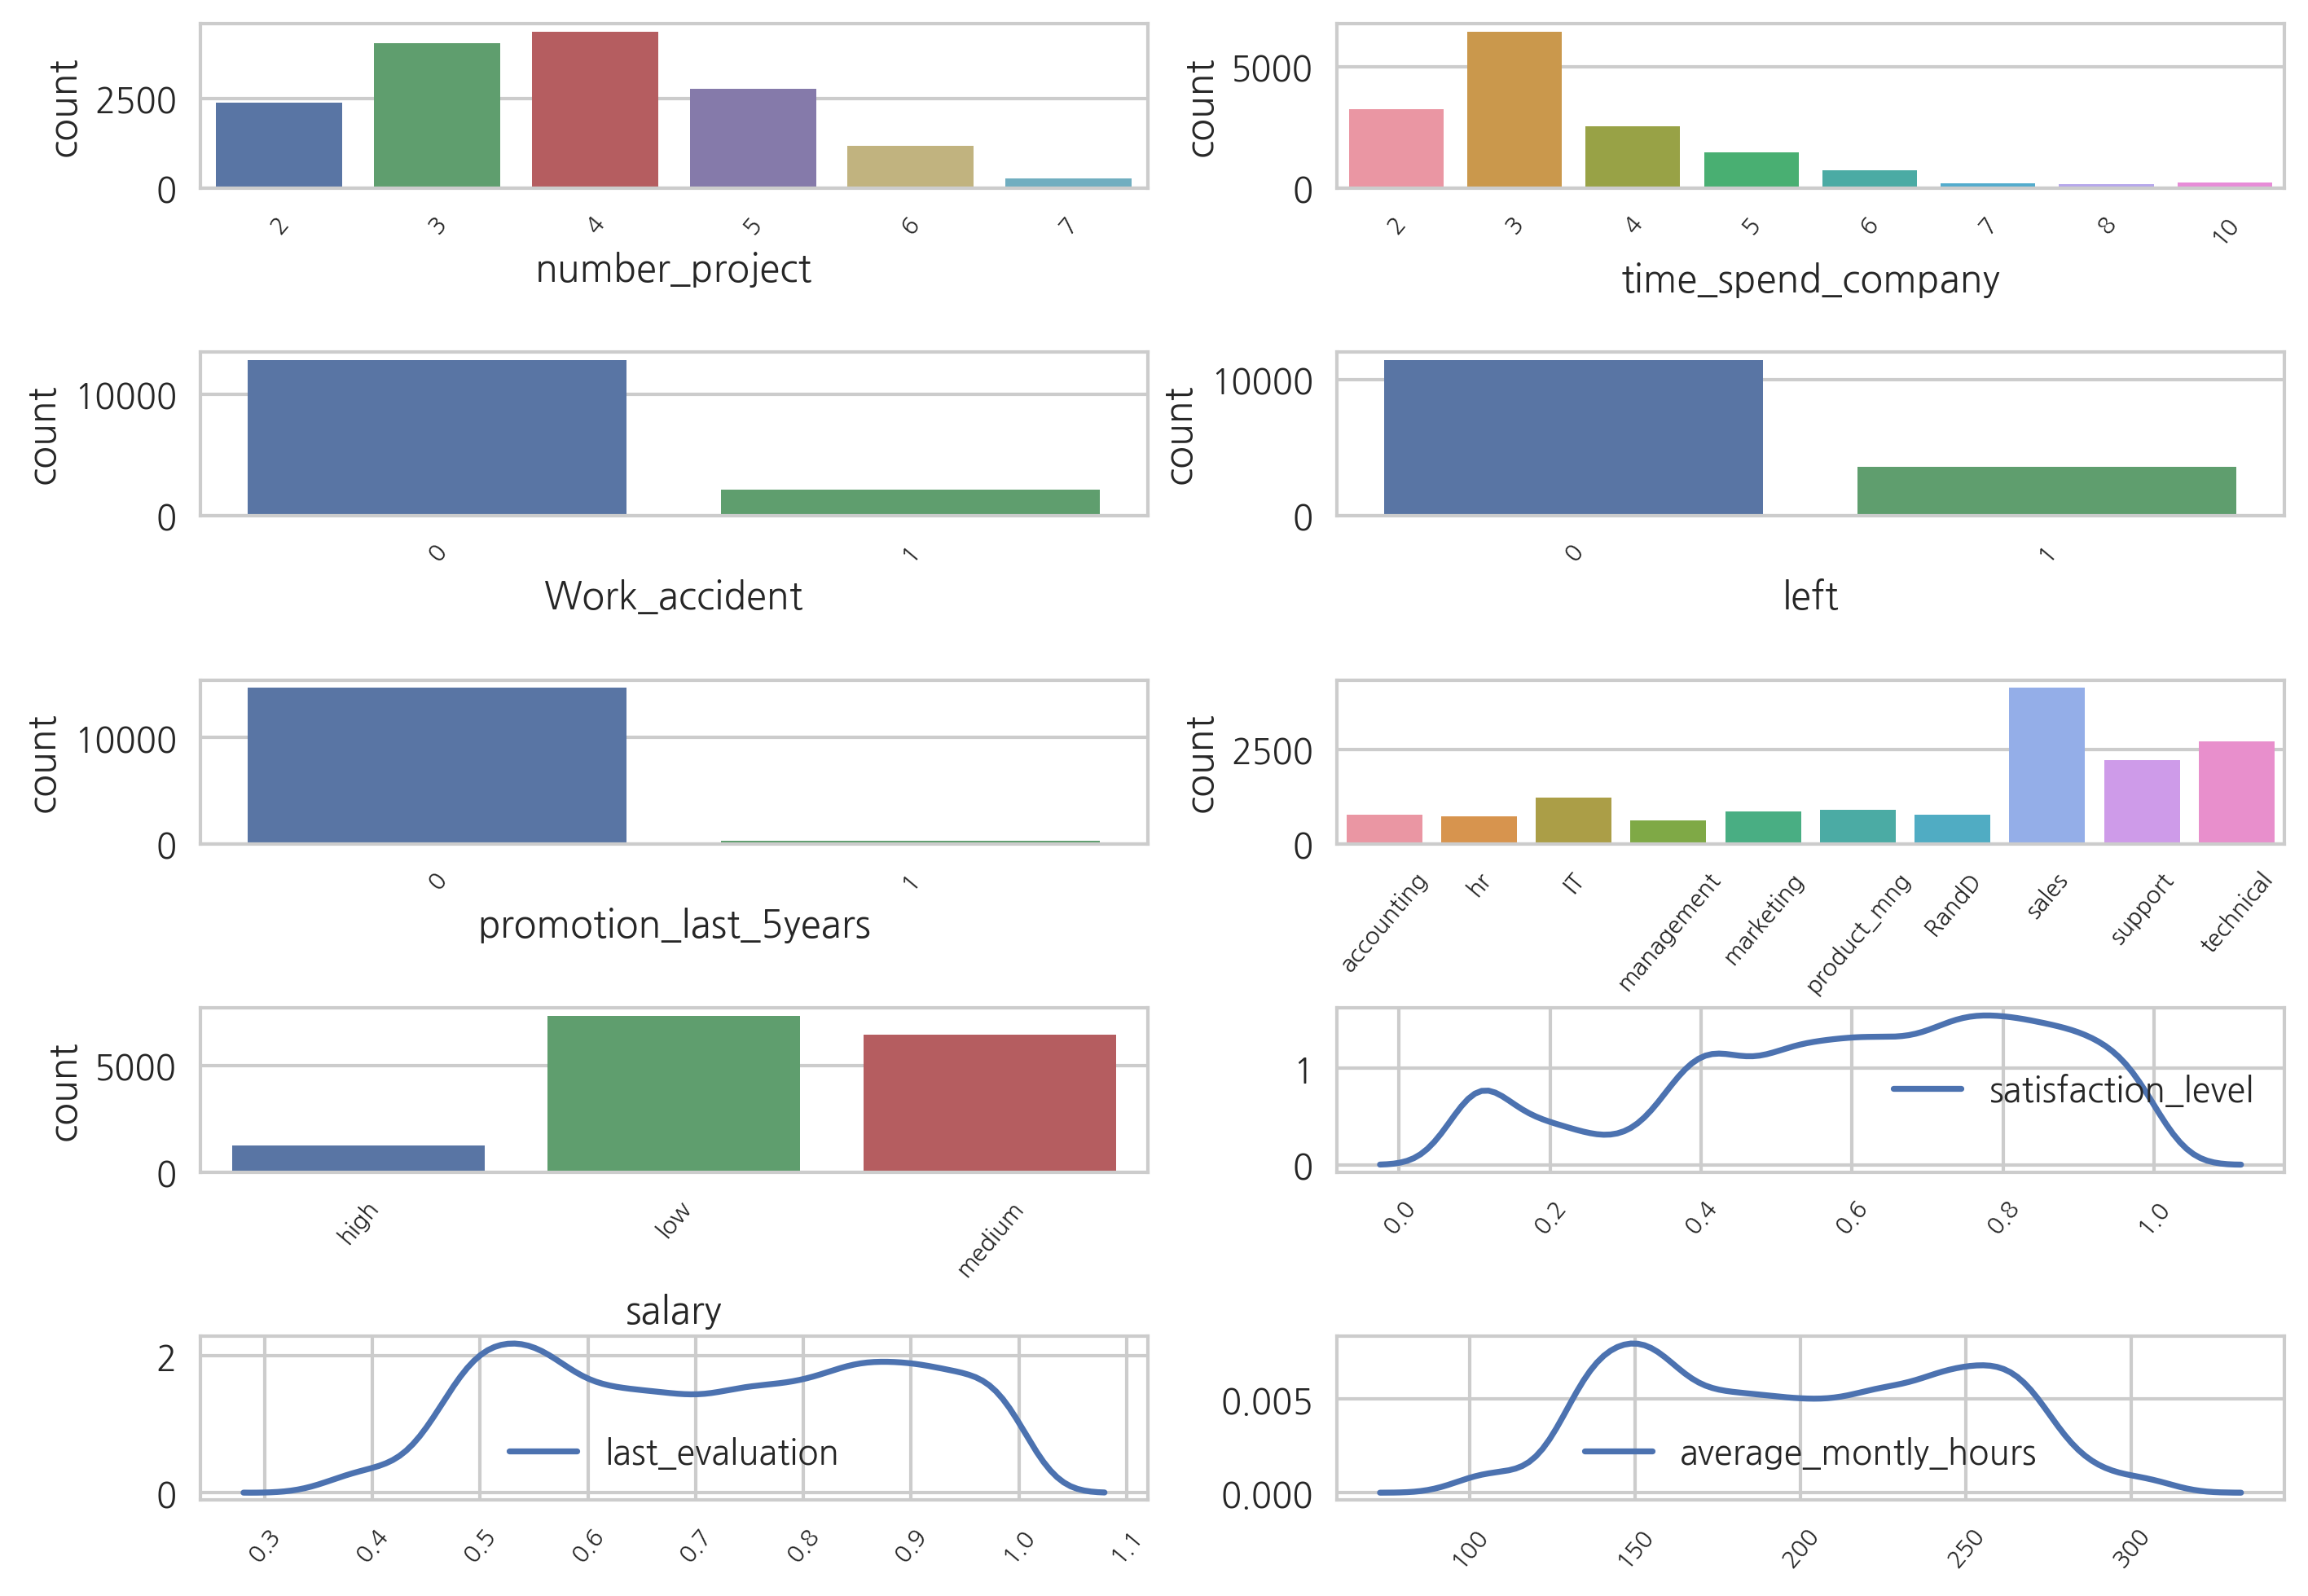

In [23]:
for i,j in enumerate(categorical):
    plt.subplot(5,2,i+1)
    sns.countplot(df_hr[j])
    plt.subplots_adjust(hspace=1)
    plt.xticks(rotation=50,fontsize=7)

for i,j in enumerate(not_categorical):
    plt.subplot(5,2,8+i)
    plt.subplots_adjust(hspace=1)
    plt.xticks(rotation=50,fontsize=7)
    sns.kdeplot(df_hr[j])

- 데이터 분포를 살펴보면 number_project의 수는 4개가 최고점을 이루고 있으며,
- 회사 근속년수는 3년이 최고점을 이루고 있으며, 1년차는 없는 것으로 봐서 저번년도는 **채용이 없던 것**으로 확인할 수 있다.
- 이직에 대한 인원이 **많은 비중**을 차지고 있었다.(계산 결과 23%)
- 이직에 대한 인원의 비중과 비교했을 때, 최근 5년간 승진여부는 확연한 차이를 확인 할 수 있으며(**승진에 대한 불만사항**이 예측가능하며)
- 월급의 순위는 low-medium-high 순이었으나, **high의 비중이 극히 일부분**이었다. 미국은 **직무급**을 기반으로 시행되기 때문에, 높은 월급을 받는 다는 것은 높은 직무에서 근무한다고 볼 수 있을텐데, high의 비중이 적다는 것과 **승진이 적다**는 것은 연결해볼 수 있는 문제로 볼 수 있다.
- 구성원의 만족도는 0.8쯤에서 최고점을 이루고 있어서 높은편이라 볼 수 있으며,
- 최신 평가결과와, 월 평균 근로시간은 두개의 극대값을 형성하는 모형이다. 두 개가 유사한 모양을 띄고 있어서 **상관관계**가 있는지 확인해보도록 하겠다.

또한, **인적자원계획** 입장에서 보면 인력의 공급은 작년에 1명도 있지 않았지만 **올해는 23% 인원**이 나갔기에 엄청난 **공급의 부족**이 예상되며
퇴사의 추세가 이대로 유지된다면 기업의 위기를 초래할 수도 있다고 본다.

### feature들 간 상관관계가 있는지 여부

In [24]:
def heatmap(df):
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        ax = sns.heatmap(corr, mask=mask, vmax=.5, square=True,cmap="YlGnBu",annot=True)
    return ax

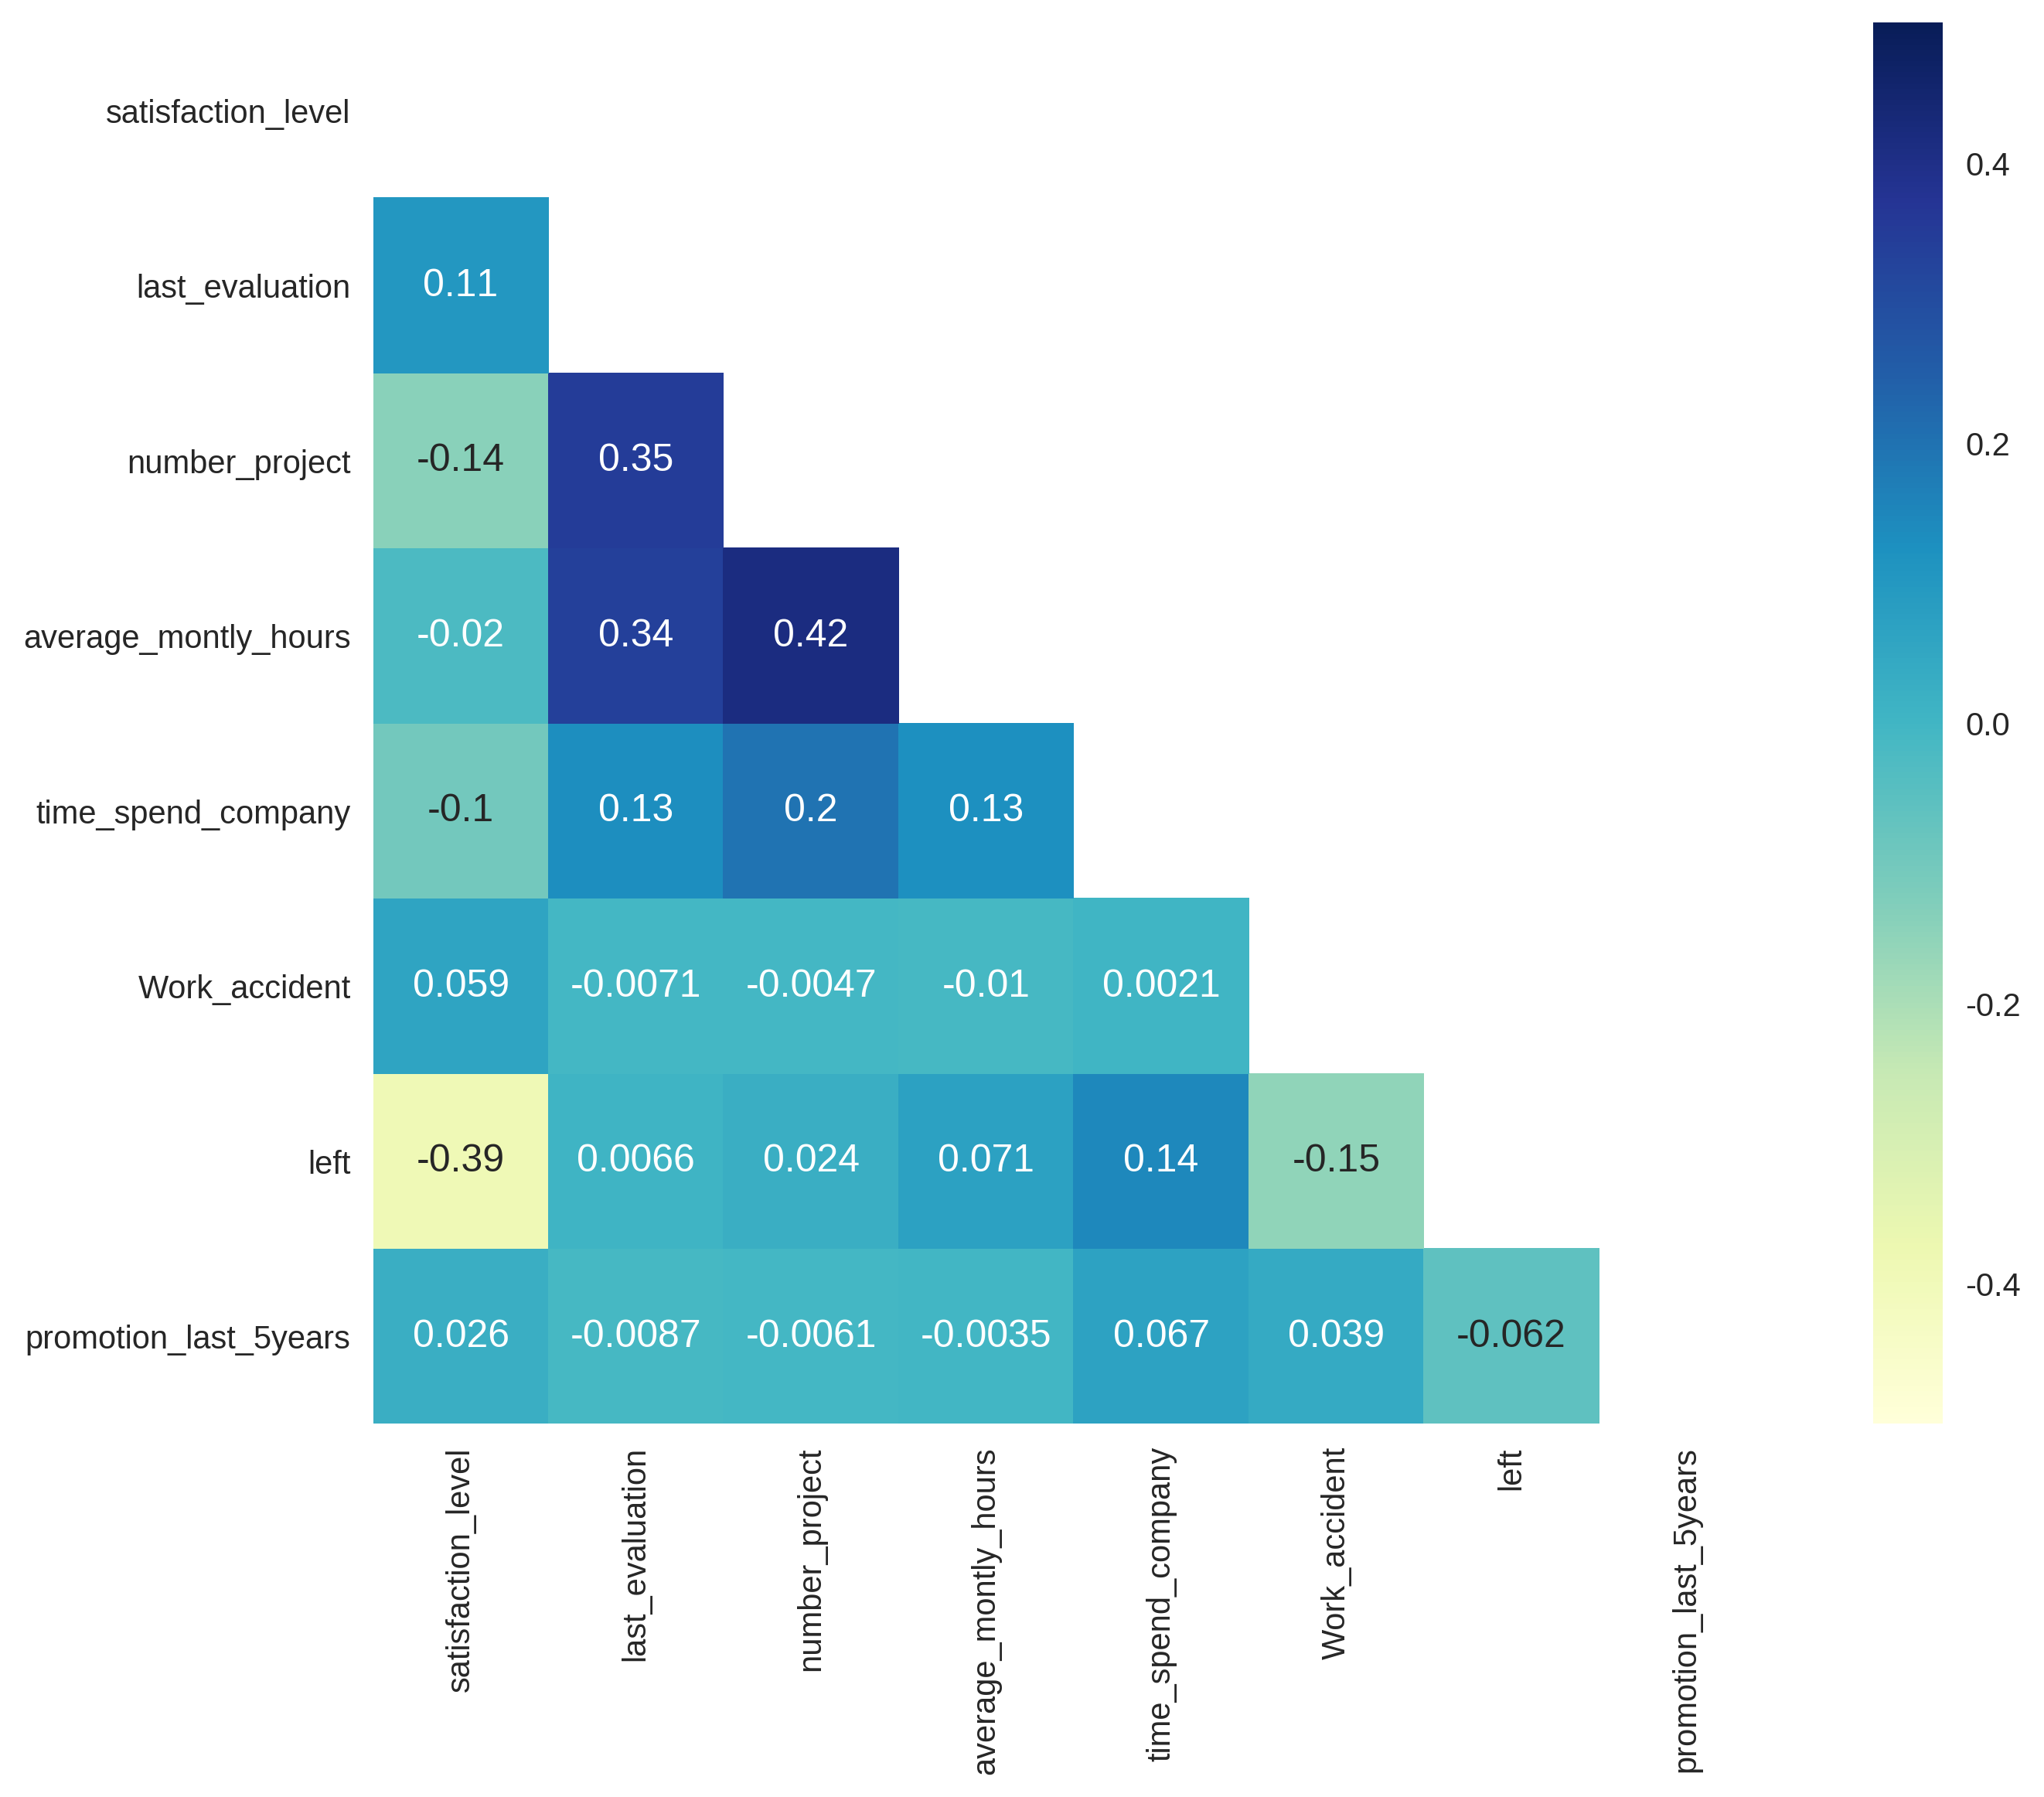

In [25]:
heatmap(df_hr)

상관관계를 살펴본 결과,
- 프로젝트의 개수, 최신 평가의 결과, 월 평균 근로시간은 서로 양의 관계가 나타나 있는 것으로 나타났으며,
- 이직과 만족도는 음의 상관관계 있는 것으로 나타났다.

강한상관관계가 아닌 약한 상관관계가 나타나므로, **데이터의 분포를 더 자세히 확인**하기 위해서 이하에서는 **퇴사인원과 잔류인원**을 구분하여 pairplot을 그려보도록 하겠다.

### 퇴사인원과 잔류인원의 pairplot

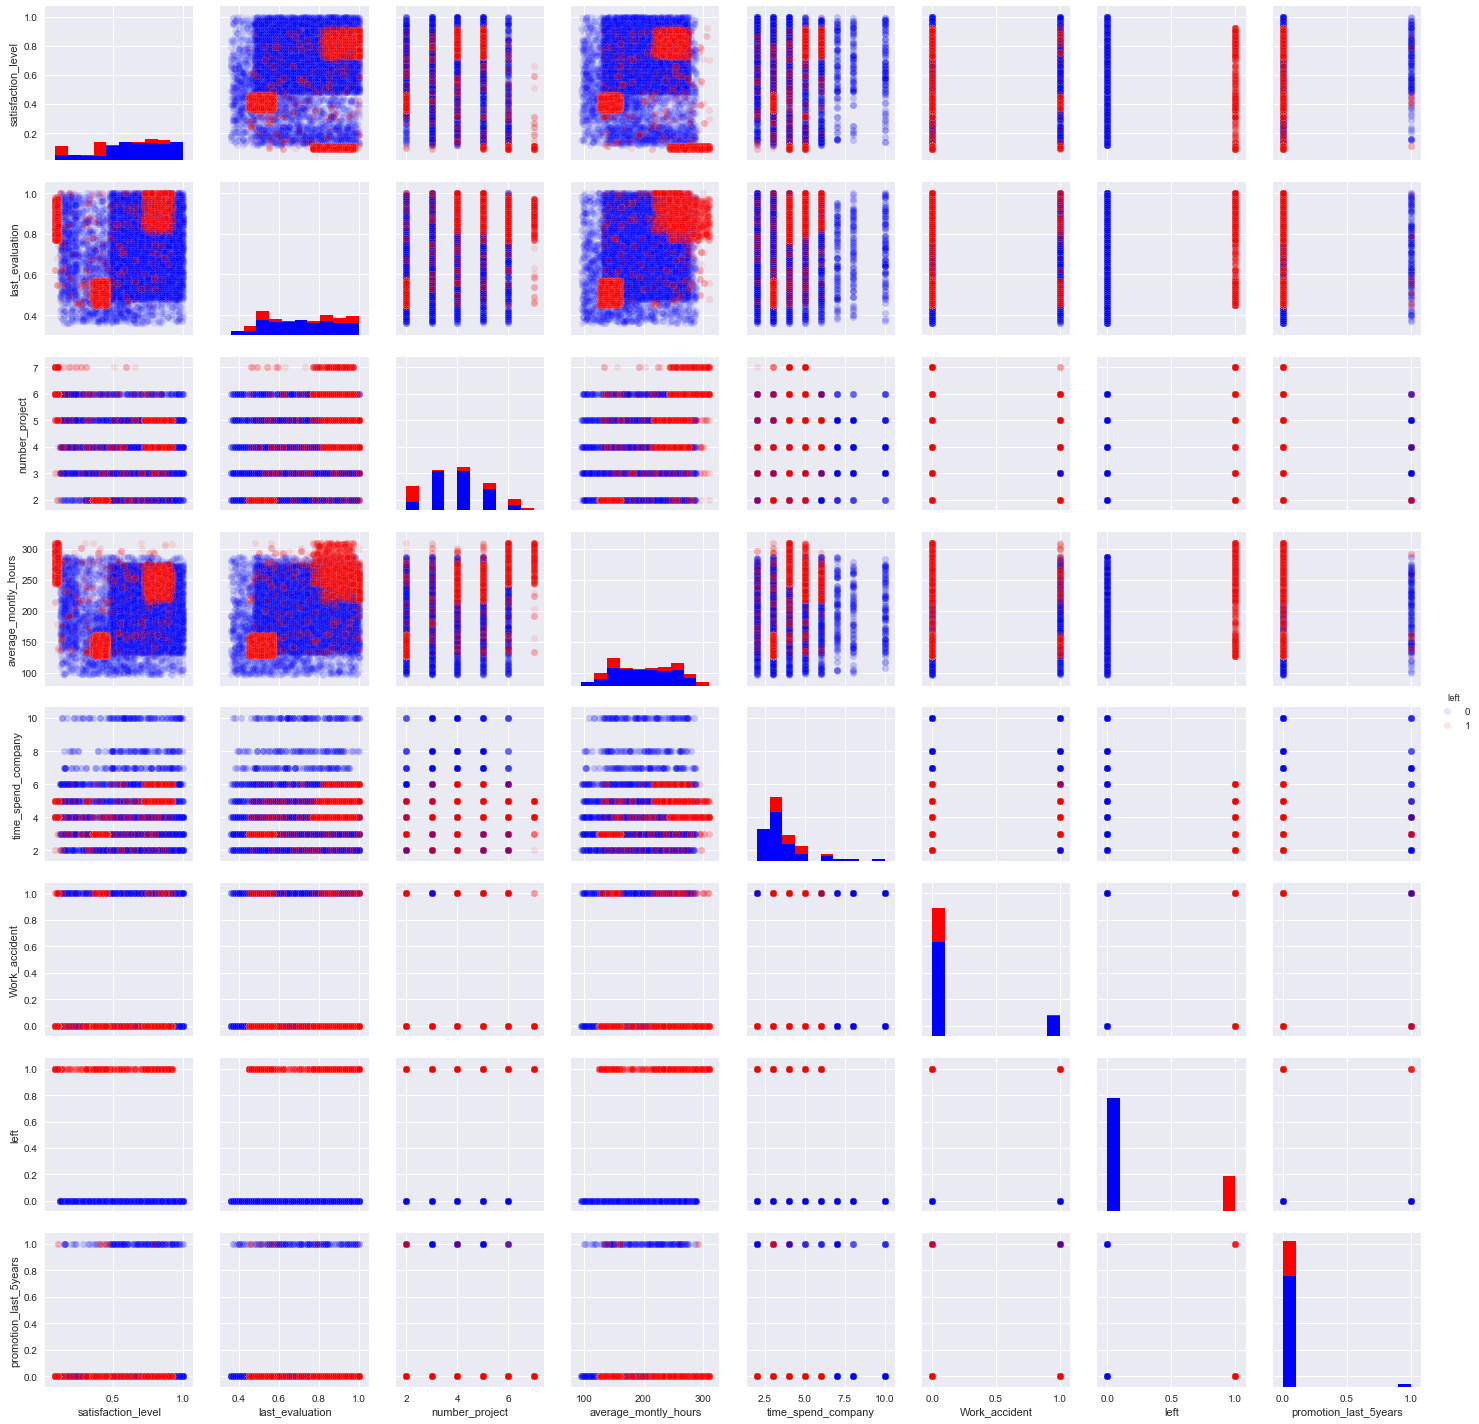

In [3]:
color = ["blue","red"]
sns.pairplot(df_hr,palette=color,hue = "left",plot_kws=dict(alpha=0.1))
plt.show()

퇴사인원의 특징을 설명하려면, 특정그룹으로 묶어낸 다음에 이들의 특징을 살펴보면 될 것이다.

- 위의 pairplot을 보면 **최신평가**와 **월 평균근로시간**은 **두 그룹의 분포**가 나타나며, 
- **만족도와 월 평균근로시간**과 **만족도와 최신평가**은 세 그룹의 분포가 나타난다.

이 그룹을 자세히 살펴보고, **our best and most experienced employees**를 찾기 위해서 이하에서는 **GE-9block의 관점**에서 데이터를 살펴보도록 하겠다.


<br />
<br />
<br />

# 2. our best and most experienced employees에 대한 정의 - GE 9 block

GE-9block에서 x축은 발전가능성 y축은 현재성과를 의미하므로 X축을 만족도, Y축을 최신평과로 두면 GE-9block의 관점에서 data를 해석할 수 있다..

![9-block.png](attachment:9-block.png)

### 그룹을 9등분 하기 - 모든인원과 현재인원

In [4]:
df_hr.quantile(q=[0.33,0.66])

satisfaction_level  last_evaluation  number_project  \
0.33                0.51             0.60             3.0   
0.66                0.76             0.82             4.0   

      average_montly_hours  time_spend_company  Work_accident  left  \
0.33                 168.0                 3.0            0.0   0.0   
0.66                 231.0                 4.0            0.0   0.0   

      promotion_last_5years  
0.33                    0.0  
0.66                    0.0

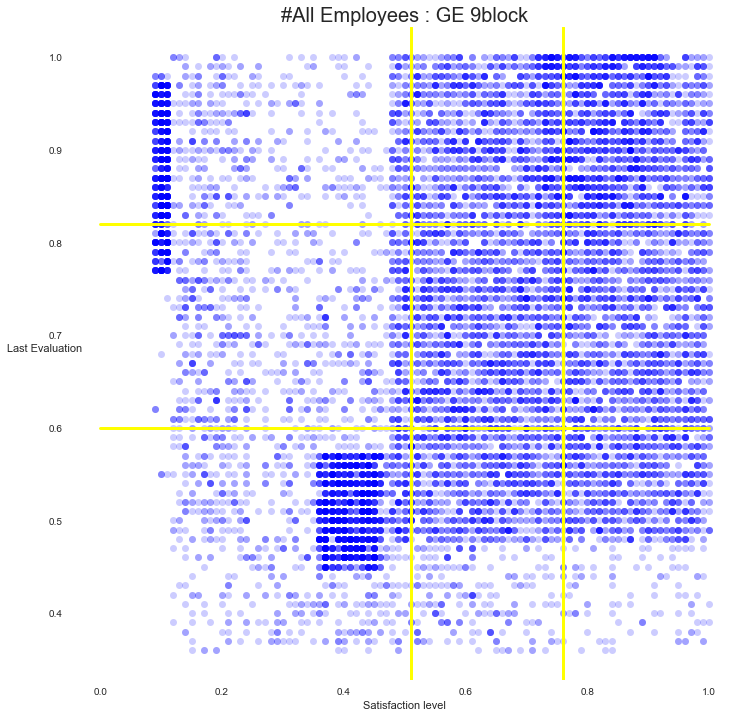

In [5]:
fig= plt.figure(num=1, figsize=(12,12))
ax = fig.add_subplot(111) 
ax.plot(df_hr.satisfaction_level,df_hr.last_evaluation,'o', alpha = 0.2,color = "b")
ax.set_facecolor('white')

plt.ylabel('Last Evaluation',rotation=0)
plt.plot([0.60,0.60],c="yellow",ls="-",lw=3)
plt.plot([0.82,0.82],c="yellow",ls="-",lw=3)
plt.axvline(x=0.51,c="yellow",ls="-",lw=3)
plt.axvline(x=0.76,c="yellow",ls="-",lw=3)
plt.title('#All Employees : GE 9block',fontsize=20)
plt.xlabel('Satisfaction level')
plt.show()


- 모든 인원의(잔류인원+퇴사인원) 경우 9-block에 의하면 2,3,4,5,8,9의 인원들이 많이 나타났다.

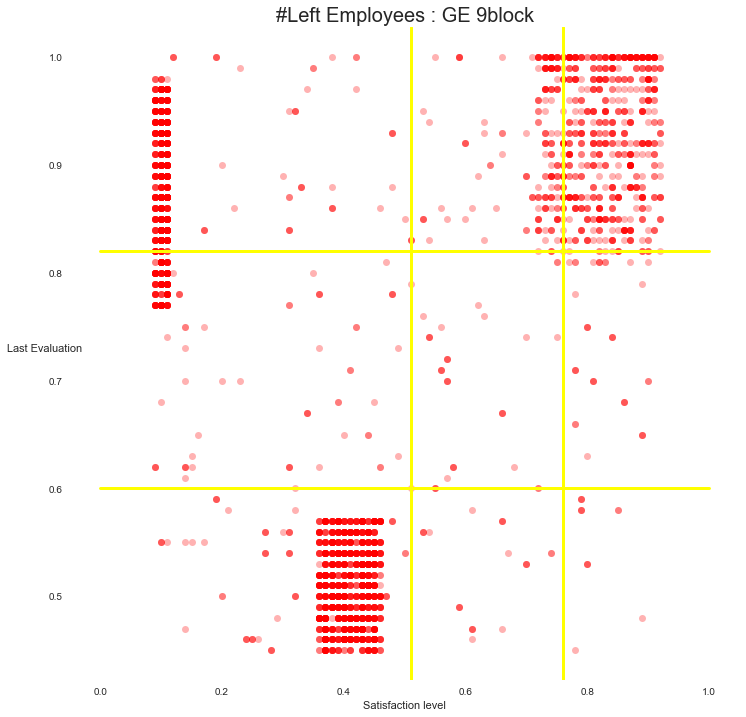

In [6]:
fig= plt.figure(num=1, figsize=(12,12))
ax = fig.add_subplot(111) 
ax.set_facecolor('white')
ax.plot(df_hr.satisfaction_level[df_hr.left==1],df_hr.last_evaluation[df_hr.left==1],'o', alpha = 0.3,color = "r")

plt.ylabel('Last Evaluation',rotation=0)
plt.plot([0.60,0.60],c="yellow",ls="-",lw=3)
plt.plot([0.82,0.82],c="yellow",ls="-",lw=3)
plt.axvline(x=0.51,c="yellow",ls="-",lw=3)
plt.axvline(x=0.76,c="yellow",ls="-",lw=3)
plt.title('#Left Employees : GE 9block',fontsize=20)
plt.xlabel('Satisfaction level')
plt.show()

- 퇴사인원의 경우 9-block에 의하면 1,7,9의 인원들이 많이 나타났다.

즉 우리가 찾는 **our best and most experienced employees는 9번의 인원**에 해당함을 알 수가 있다.

**1번의 경우**에는 **퇴사를 하여도 오히려 조직의 입장에서는 도움이 되는** 인원들이며,

**7번의 경우**에는 **현재 조직이 처한 상황**에 따라 가치가 달라질 수 인원이다.(1목차에서 살펴본 인적자원 계획에 의하면 작년채용은 없었고 대거 이직을 했으므로 7번의 경우는 중요한 인원들이다.)

### 이직자들의 cluster별 묶어주기

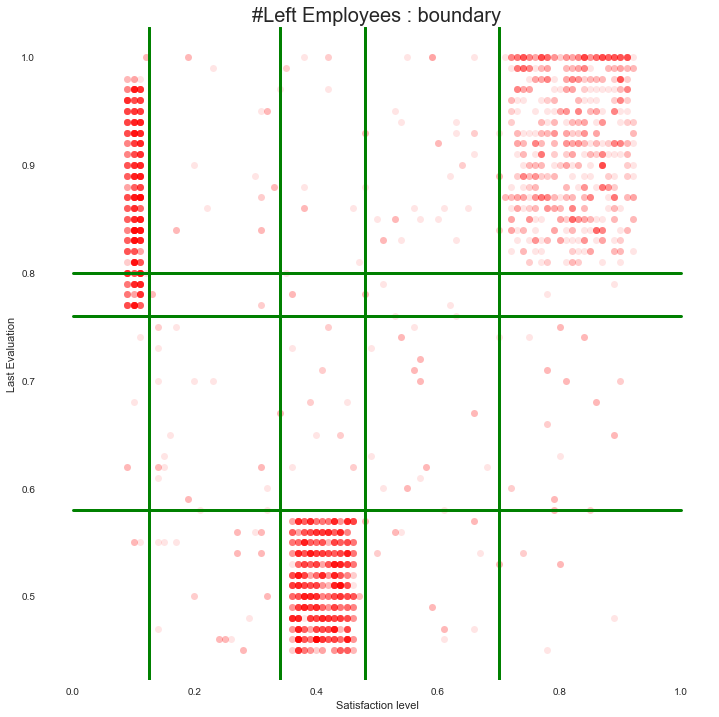

In [7]:
fig= plt.figure(num=1, figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_facecolor('white')
ax.plot(df_hr.satisfaction_level[df_hr.left ==1],df_hr.last_evaluation[df_hr.left ==1],'o', alpha = 0.1,c="r")
plt.ylabel('Last Evaluation')
plt.plot([0.76,0.76],c="green",ls="-",lw=3)
plt.plot([0.58,0.58],c="green",ls="-",lw=3)
plt.plot([0.8,0.8],c="green",ls="-",lw=3)
plt.axvline(x=0.125,c="green",ls="-",lw=3)
plt.axvline(x=0.34,c="green",ls="-",lw=3)
plt.axvline(x=0.48,c="green",ls="-",lw=3)
plt.axvline(x=0.7,c="green",ls="-",lw=3)
plt.title('#Left Employees : boundary',fontsize=20)
plt.xlabel('Satisfaction level')
plt.show()

- 각 cluster별의 경계값을 찾아주기 위해 위와 같이 시각화를 해주었다. 
- cluster 기법인 kmeans 등을 쓰지 않는 이유는 **해당 범위외의 data가 묶이지 않기** 위해서이다.

### cluster별로 묶어주기 이전에 표준화해주기

In [26]:
df_hr["salary"] = df_hr["salary"].replace({"high":3,"medium":2,"low":1})

In [27]:
scaler = MinMaxScaler()

In [28]:
df_hr[[u'number_project',u'average_montly_hours', u'time_spend_company', u'Work_accident', u'promotion_last_5years',u'salary']]= scaler.fit_transform(df_hr[[u'number_project', u'average_montly_hours', u'time_spend_company', u'Work_accident', u'promotion_last_5years',u'salary']])

### 해당 경계값을 근거로 묶어주기
- cluster 1 : (0.7-1, 0.8-1) / Star
- cluster 2 : (0.34-0.48, 0-0.58) / Termination risk 
- cluster 3 : (0-0.125,0.76-1) / Professional subject expert

In [3]:
df_cluster_1 = df_hr[df_hr.satisfaction_level >0.7][df_hr.last_evaluation>0.8][df_hr.left == 1]
df_cluster_2 = df_hr[df_hr.satisfaction_level >0.34][df_hr.satisfaction_level <0.48][df_hr.last_evaluation<0.58][df_hr.left == 1]
df_cluster_3 = df_hr[df_hr.satisfaction_level <0.125][df_hr.last_evaluation>0.76][df_hr.left == 1]

C:\Users\hapro\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\hapro\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\Users\hapro\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


<br />
<br />
<br />

# 3. Left reason(3_cluster) - PCA분석 및 graph

### PCA 과정

In [30]:
def PCA_n(df):
    X_std = df.loc[:,[u'satisfaction_level', u'last_evaluation', u'number_project',u'average_montly_hours', u'time_spend_company', u'promotion_last_5years', u'salary',u'Work_accident']]
    mean_vec = np.mean(X_std, axis=0)
    cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
    cov_mat = np.cov(X_std.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    u,s,v = np.linalg.svd(X_std.T)
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    
    with plt.style.context('seaborn-whitegrid'):
         plt.figure(figsize=(6, 4))

         plt.bar(range(8), var_exp, alpha=0.5, align='center',label='individual explained variance')
         plt.step(range(8), cum_var_exp, where='mid',label='cumulative explained variance')
         plt.ylabel('Explained variance ratio')
         plt.xlabel('Principal components')
         plt.legend(loc='best')
         plt.tight_layout()
         plt.show()
    
    matrix_w = eig_pairs[0][1].reshape(-1,1)
    
    for i in range(5):
        matrix_w = np.hstack((matrix_w,eig_pairs[i+1][1].reshape(-1,1)))
        pass
    
    return pd.DataFrame(matrix_w,index=[u'satisfaction_level', u'last_evaluation', u'number_project',u'average_montly_hours', u'time_spend_company', u'promotion_last_5years',u'salay',u'Work_accident'])

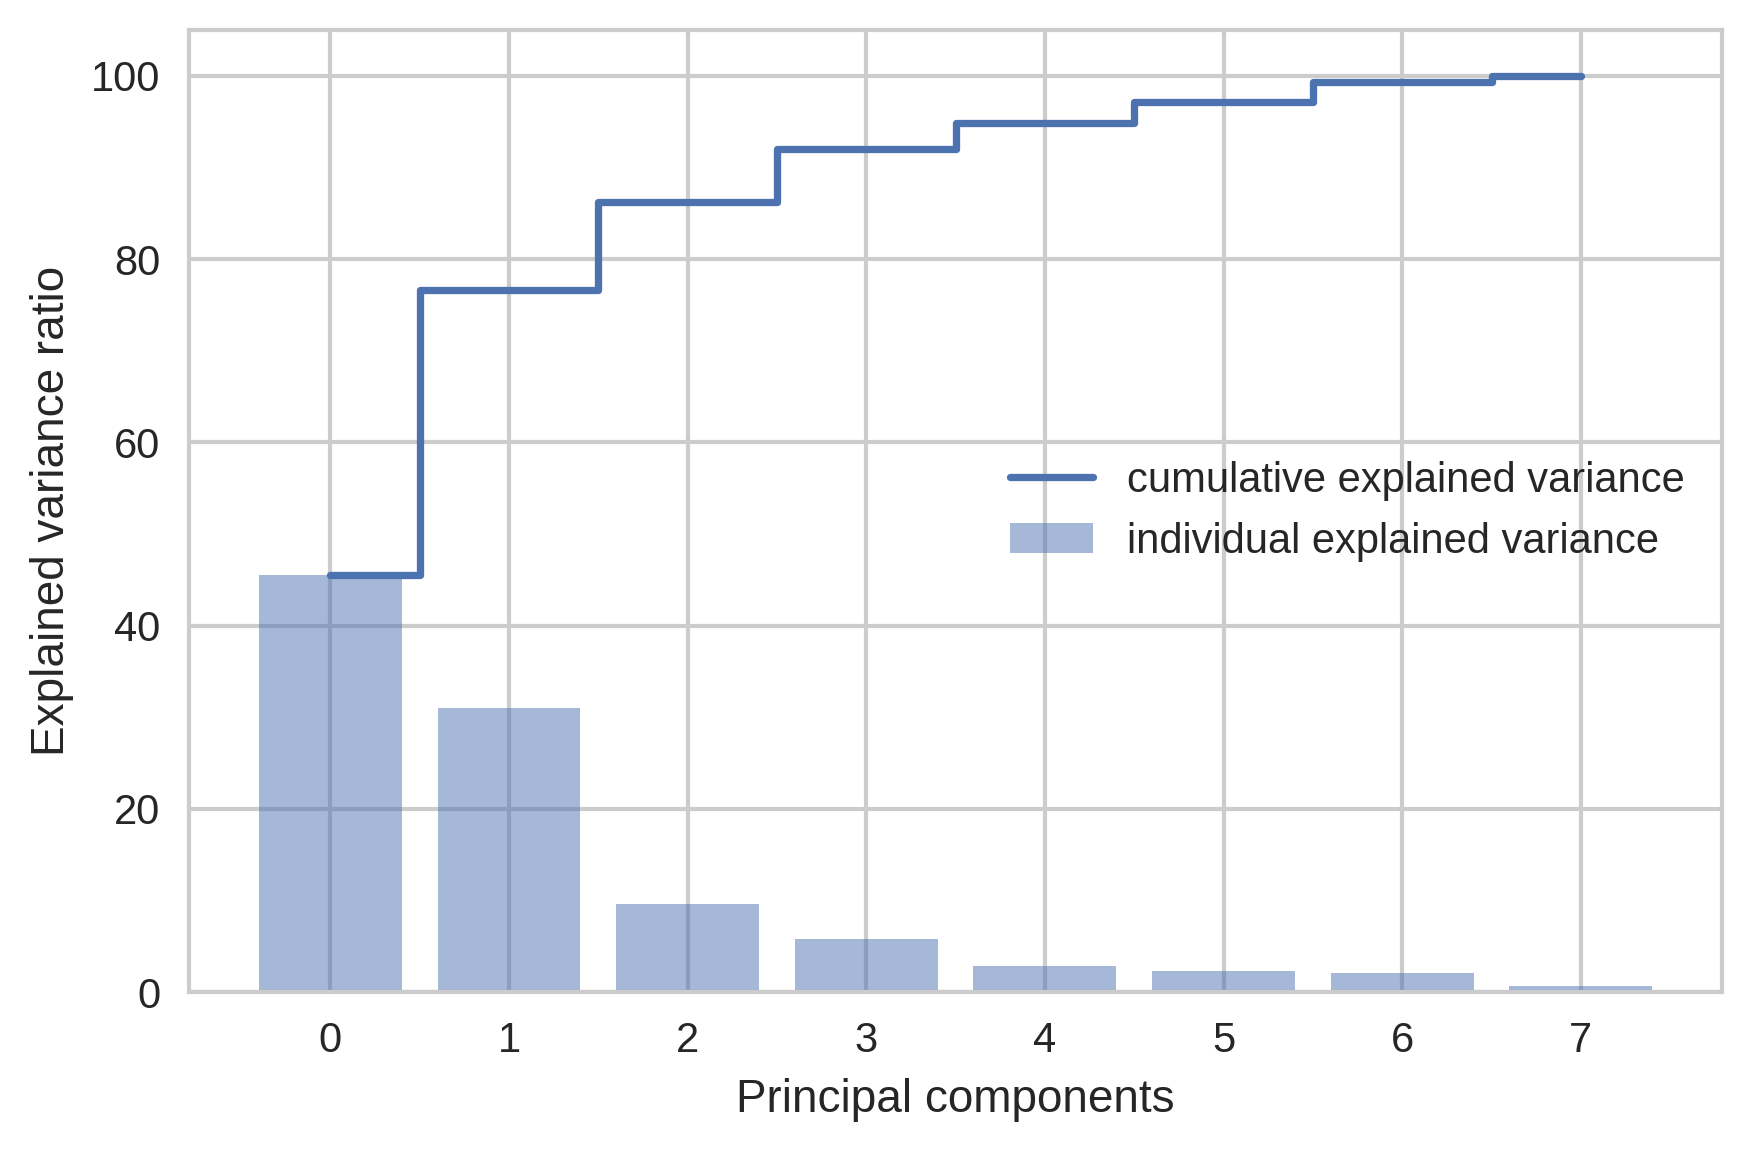

0         1         2         3         4  \
satisfaction_level    -0.000516  0.019540  0.015542  0.087172  0.304903   
last_evaluation       -0.002437 -0.024643 -0.013718 -0.032498  0.285282   
number_project        -0.008631  0.014975  0.955018 -0.270112 -0.105146   
average_montly_hours  -0.014009 -0.037529  0.244497  0.945155 -0.190684   
time_spend_company    -0.013037 -0.005526  0.165700  0.152182  0.882087   
promotion_last_5years  0.009381  0.019740 -0.007794  0.018299  0.008839   
salay                  0.953342 -0.301298  0.014649  0.000794  0.008231   
Work_accident          0.301004  0.951934 -0.000299  0.039635  0.002805   

                              5  
satisfaction_level    -0.459475  
last_evaluation       -0.790032  
number_project        -0.056531  
average_montly_hours  -0.063254  
time_spend_company     0.394344  
promotion_last_5years -0.044089  
salay                  0.004629  
Work_accident         -0.007956

In [31]:
PCA_n(df_cluster_1)

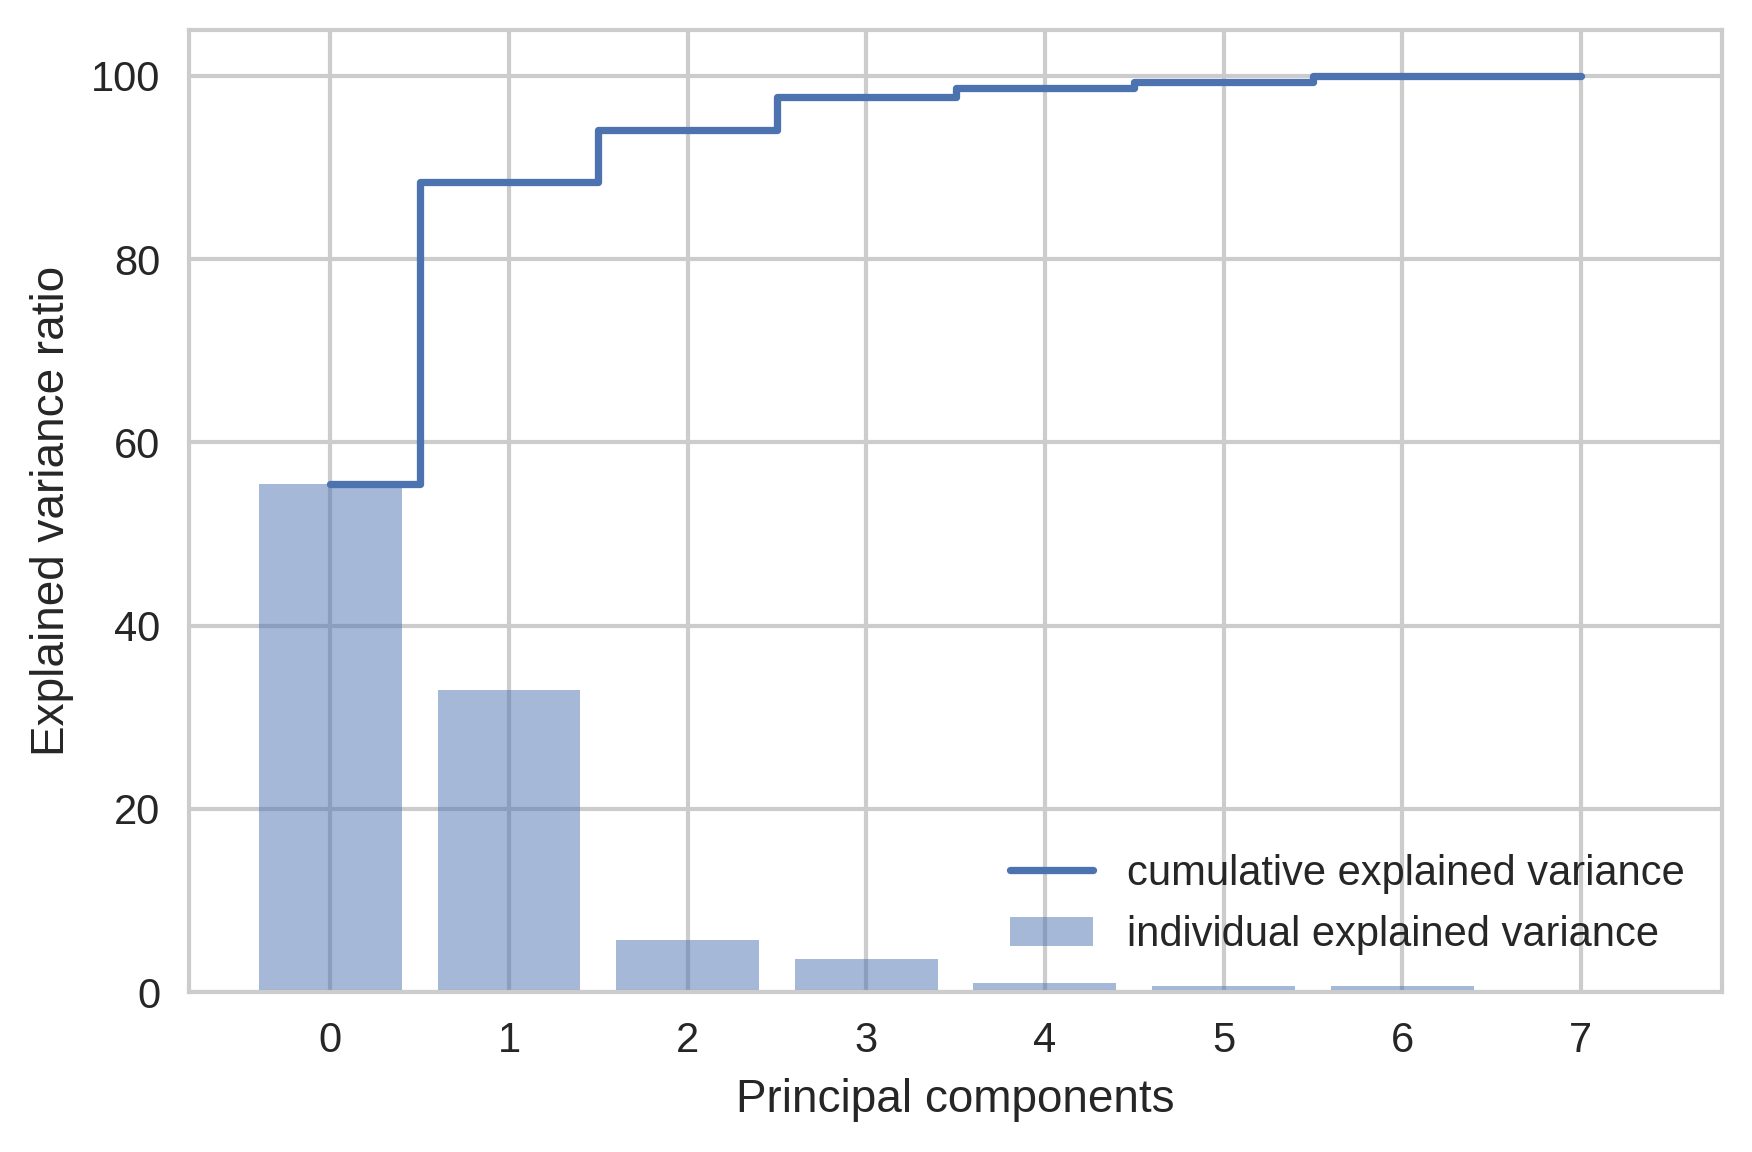

0         1         2         3         4  \
satisfaction_level    -0.004110 -0.004909  0.024804  0.005221  0.149742   
last_evaluation        0.006240  0.003763 -0.007605  0.009482  0.988418   
number_project         0.003597  0.003338  0.015605  0.367122  0.013349   
average_montly_hours   0.005838 -0.004923  0.086167  0.925003 -0.016322   
time_spend_company     0.000287  0.000522  0.001783  0.045087  0.009908   
promotion_last_5years  0.005036 -0.042781  0.994870 -0.086031  0.005105   
salay                 -0.999882 -0.010595  0.004971  0.006342  0.005564   
Work_accident          0.010416 -0.998991 -0.043179  0.000319  0.002840   

                              5  
satisfaction_level    -0.399038  
last_evaluation        0.078864  
number_project        -0.834732  
average_montly_hours   0.339518  
time_spend_company    -0.149876  
promotion_last_5years -0.005587  
salay                  0.001020  
Work_accident         -0.002054

In [32]:
PCA_n(df_cluster_2)

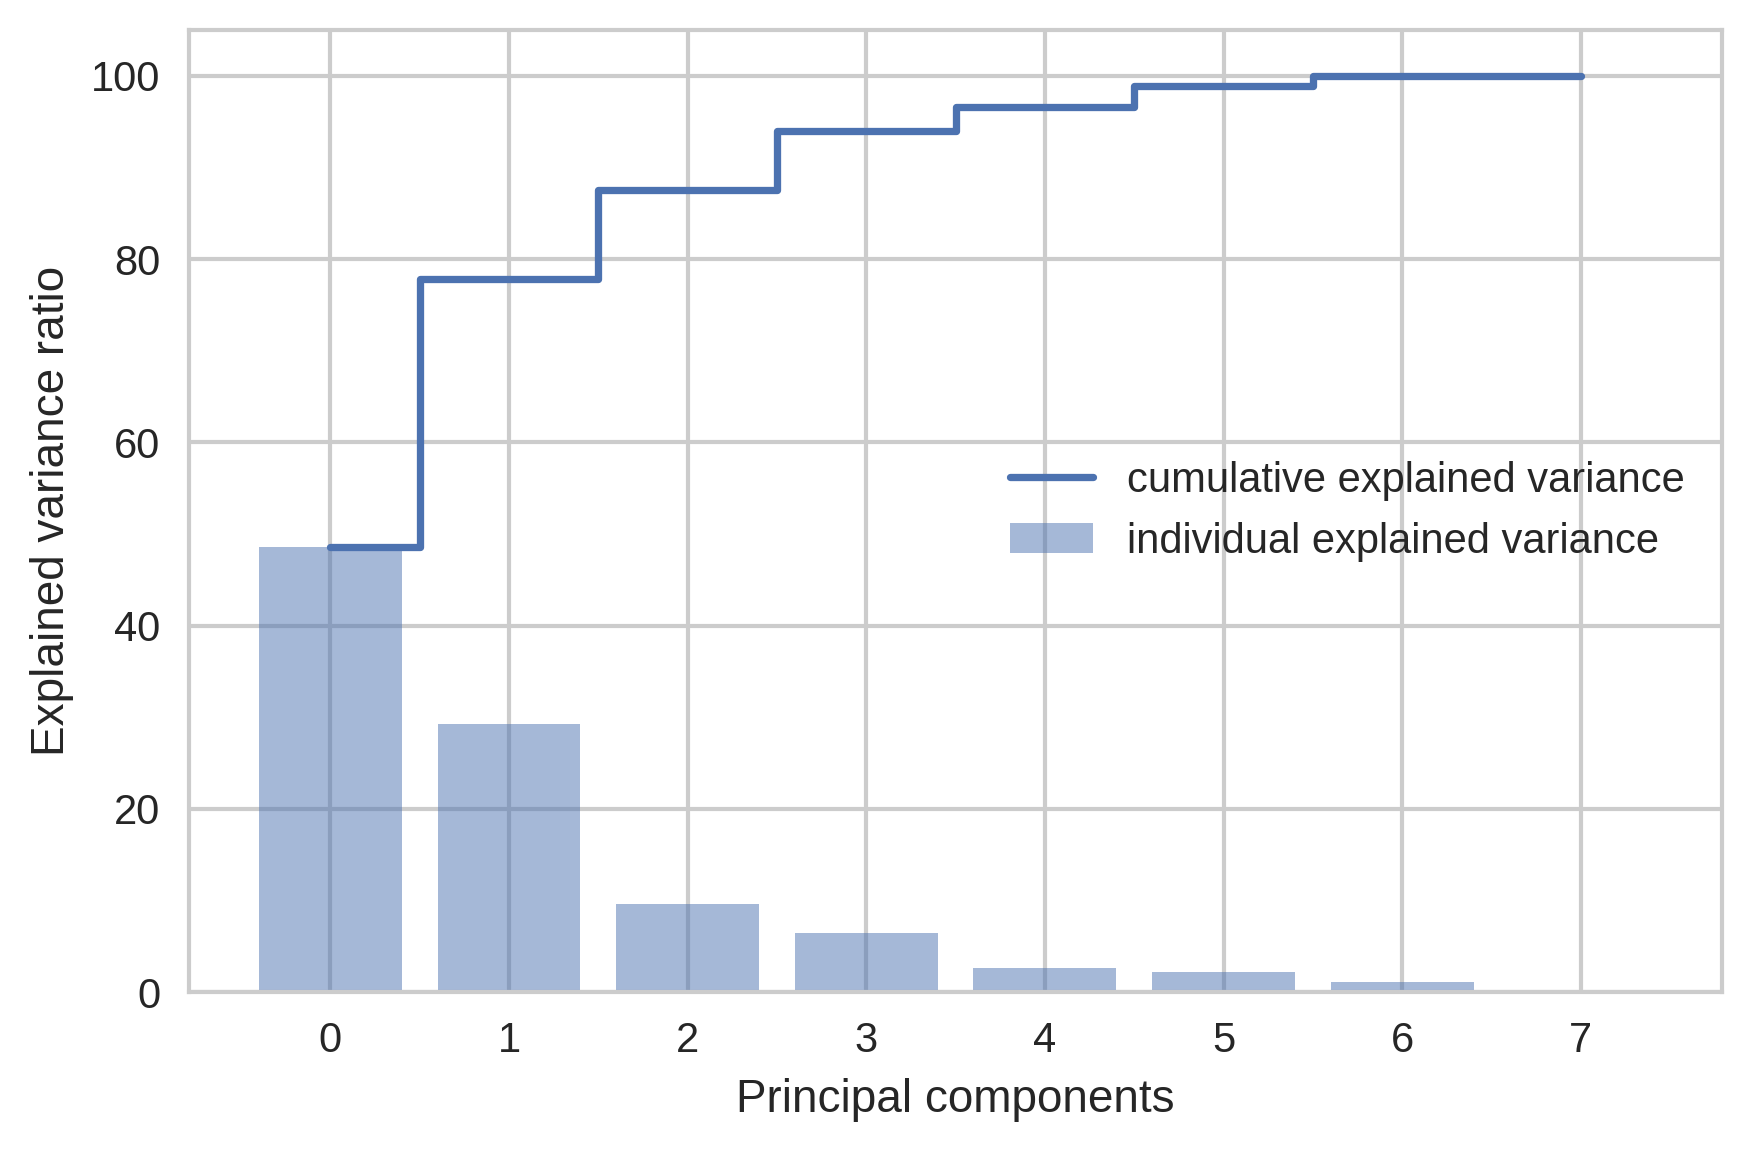

0         1         2         3         4  \
satisfaction_level    -0.001461  0.001286 -0.002098  0.004849 -0.003170   
last_evaluation        0.010671  0.012462  0.042226 -0.048090  0.851913   
number_project        -0.004243 -0.047712  0.896990 -0.431646 -0.061660   
average_montly_hours  -0.017686 -0.012141  0.432817  0.899268  0.043787   
time_spend_company     0.006373  0.001427  0.062463  0.007966 -0.019894   
promotion_last_5years -0.010663 -0.005531 -0.004875  0.047895 -0.517369   
salay                  0.995548  0.090301  0.014839  0.014191 -0.015365   
Work_accident         -0.091007  0.994602  0.046323 -0.010166 -0.014547   

                              5  
satisfaction_level     0.007209  
last_evaluation        0.518244  
number_project        -0.006768  
average_montly_hours  -0.020768  
time_spend_company    -0.041210  
promotion_last_5years  0.853919  
salay                  0.003233  
Work_accident         -0.002567

In [33]:
PCA_n(df_cluster_3)

보통의 주성분이 실수형으로만 이루어진 경우에는 PCA 주성분에 이름(naming)을 붙인 뒤에 의미를 해석한다.

하지만 이 경우에는 연속형 자료가 아닌 카테고리 및 정수 값이 주성분에 크게 나온것을 알 수가 있다.(실수형 보다 **데이터의 분산정도**가 커지기 때문에) 따라서 주성분을 naming하기 보다는 clsuter별 **원성분이 주성분에 차지하는 비중**으로 cluster간 비교를 하도록 하겠다.


첫번째 주성분에서는 cluster별로 3개구간 밖에 없는 salary의 차지하는 비중이 제일 컷으며,
두 번째 주성분에는 2개구간이 존재하는 Work_accident의 차지하는 비중이 제일 컷다.

**cluster1과 cluster3**의 세번째 주성분에서는 **number_project, average_montly_hours,time_spend_company**순으로 차지하는 비중이 컸으나,
**cluster 2**에서는 **승진의 여부**가 가장 큰 차지를 하고 있었다. 좀 더 구체적으로 살펴보기 위해서 PCA biplot을 그려보았다.

### PCA biplot 그리기

In [34]:
def PCA_biplot(df,k_1,k_2):
    
    dat = df.loc[:,[u'satisfaction_level', u'last_evaluation', u'number_project',u'average_montly_hours', u'time_spend_company', u'promotion_last_5years',u'salary',u'Work_accident']]
    n = len(dat.columns)
    pca = PCA(n_components = n)
    pca.fit(dat)

    xvector = pca.components_[k_1] 
    yvector = pca.components_[k_2]
    xs = pca.transform(dat)[:,k_1] 
    ys = pca.transform(dat)[:,k_2]

    for i in range(len(xvector)):
        plt.arrow(0, 0, xvector[i]*max(xs)/2, yvector[i]*max(ys)/2,color='r', width=0.0009, head_width=0.0025)
        plt.text(xvector[i]*max(xs)/2-0.01, yvector[i]*max(ys)/2-0.01,list(dat.columns.values)[i], color='r',fontsize=7)

    for i in range(len(xs)):
        plt.plot(xs[i], ys[i], 'bo',alpha=0.2)
    
    plt.show()
    

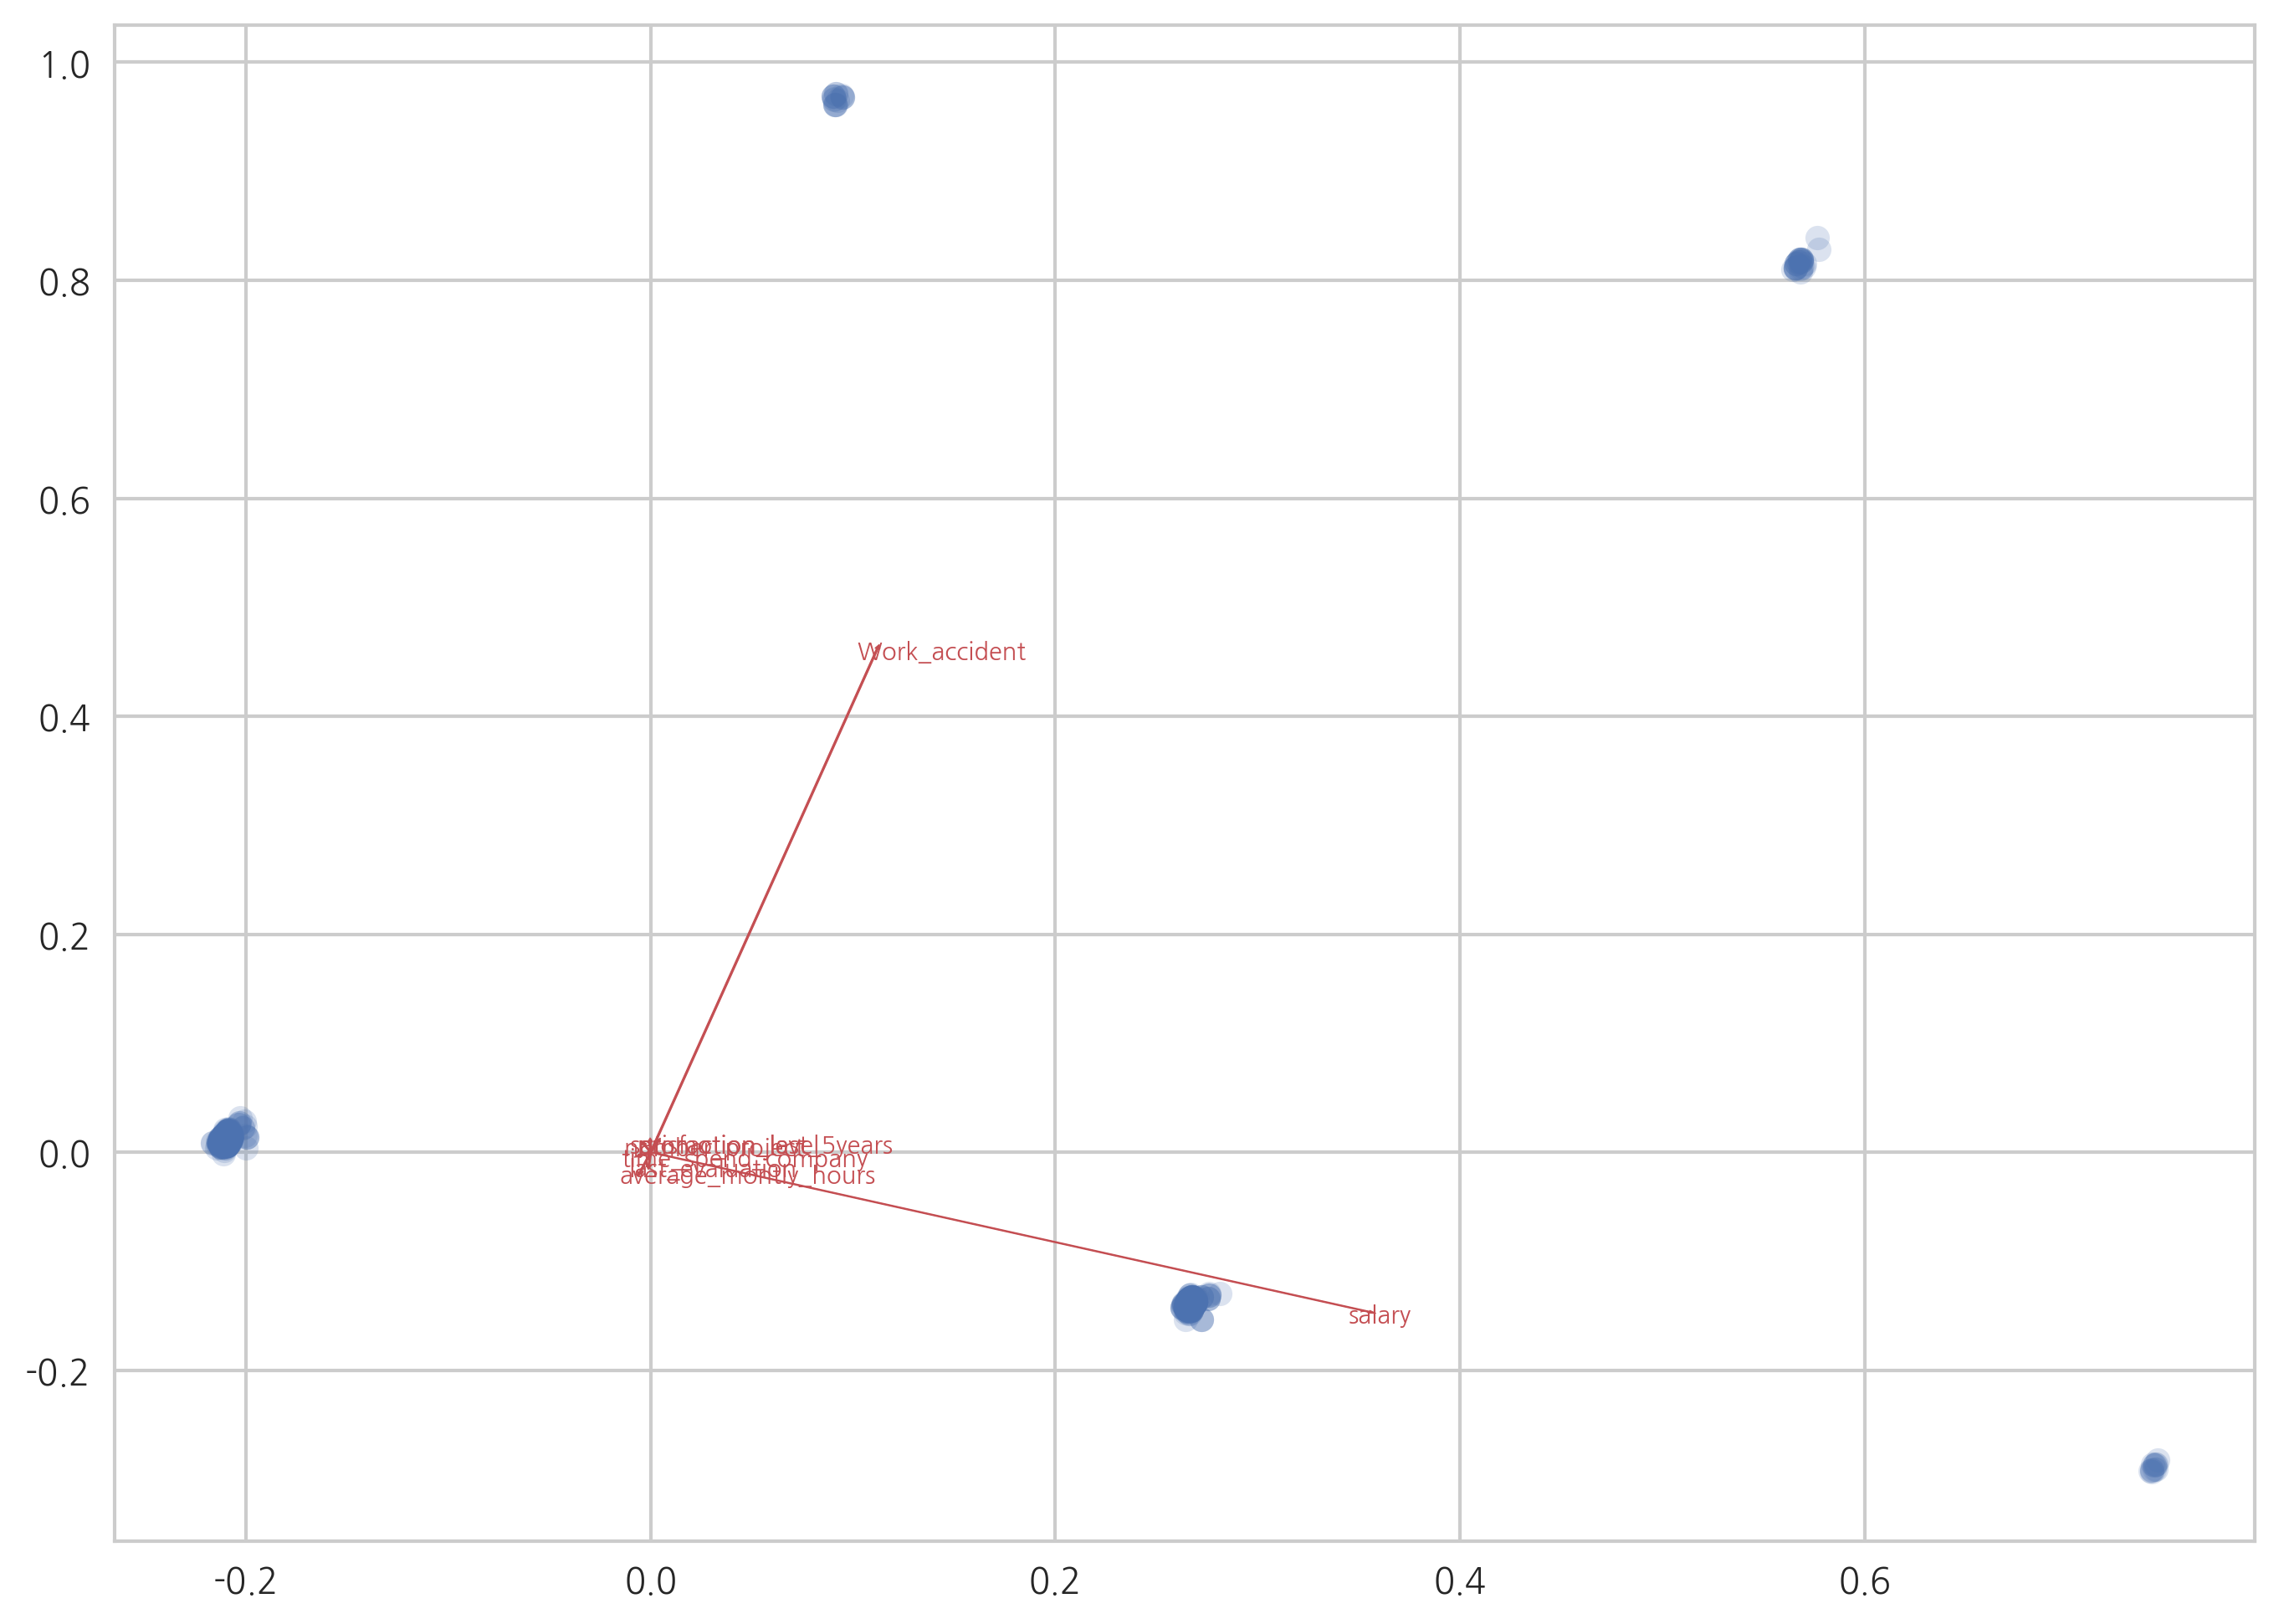

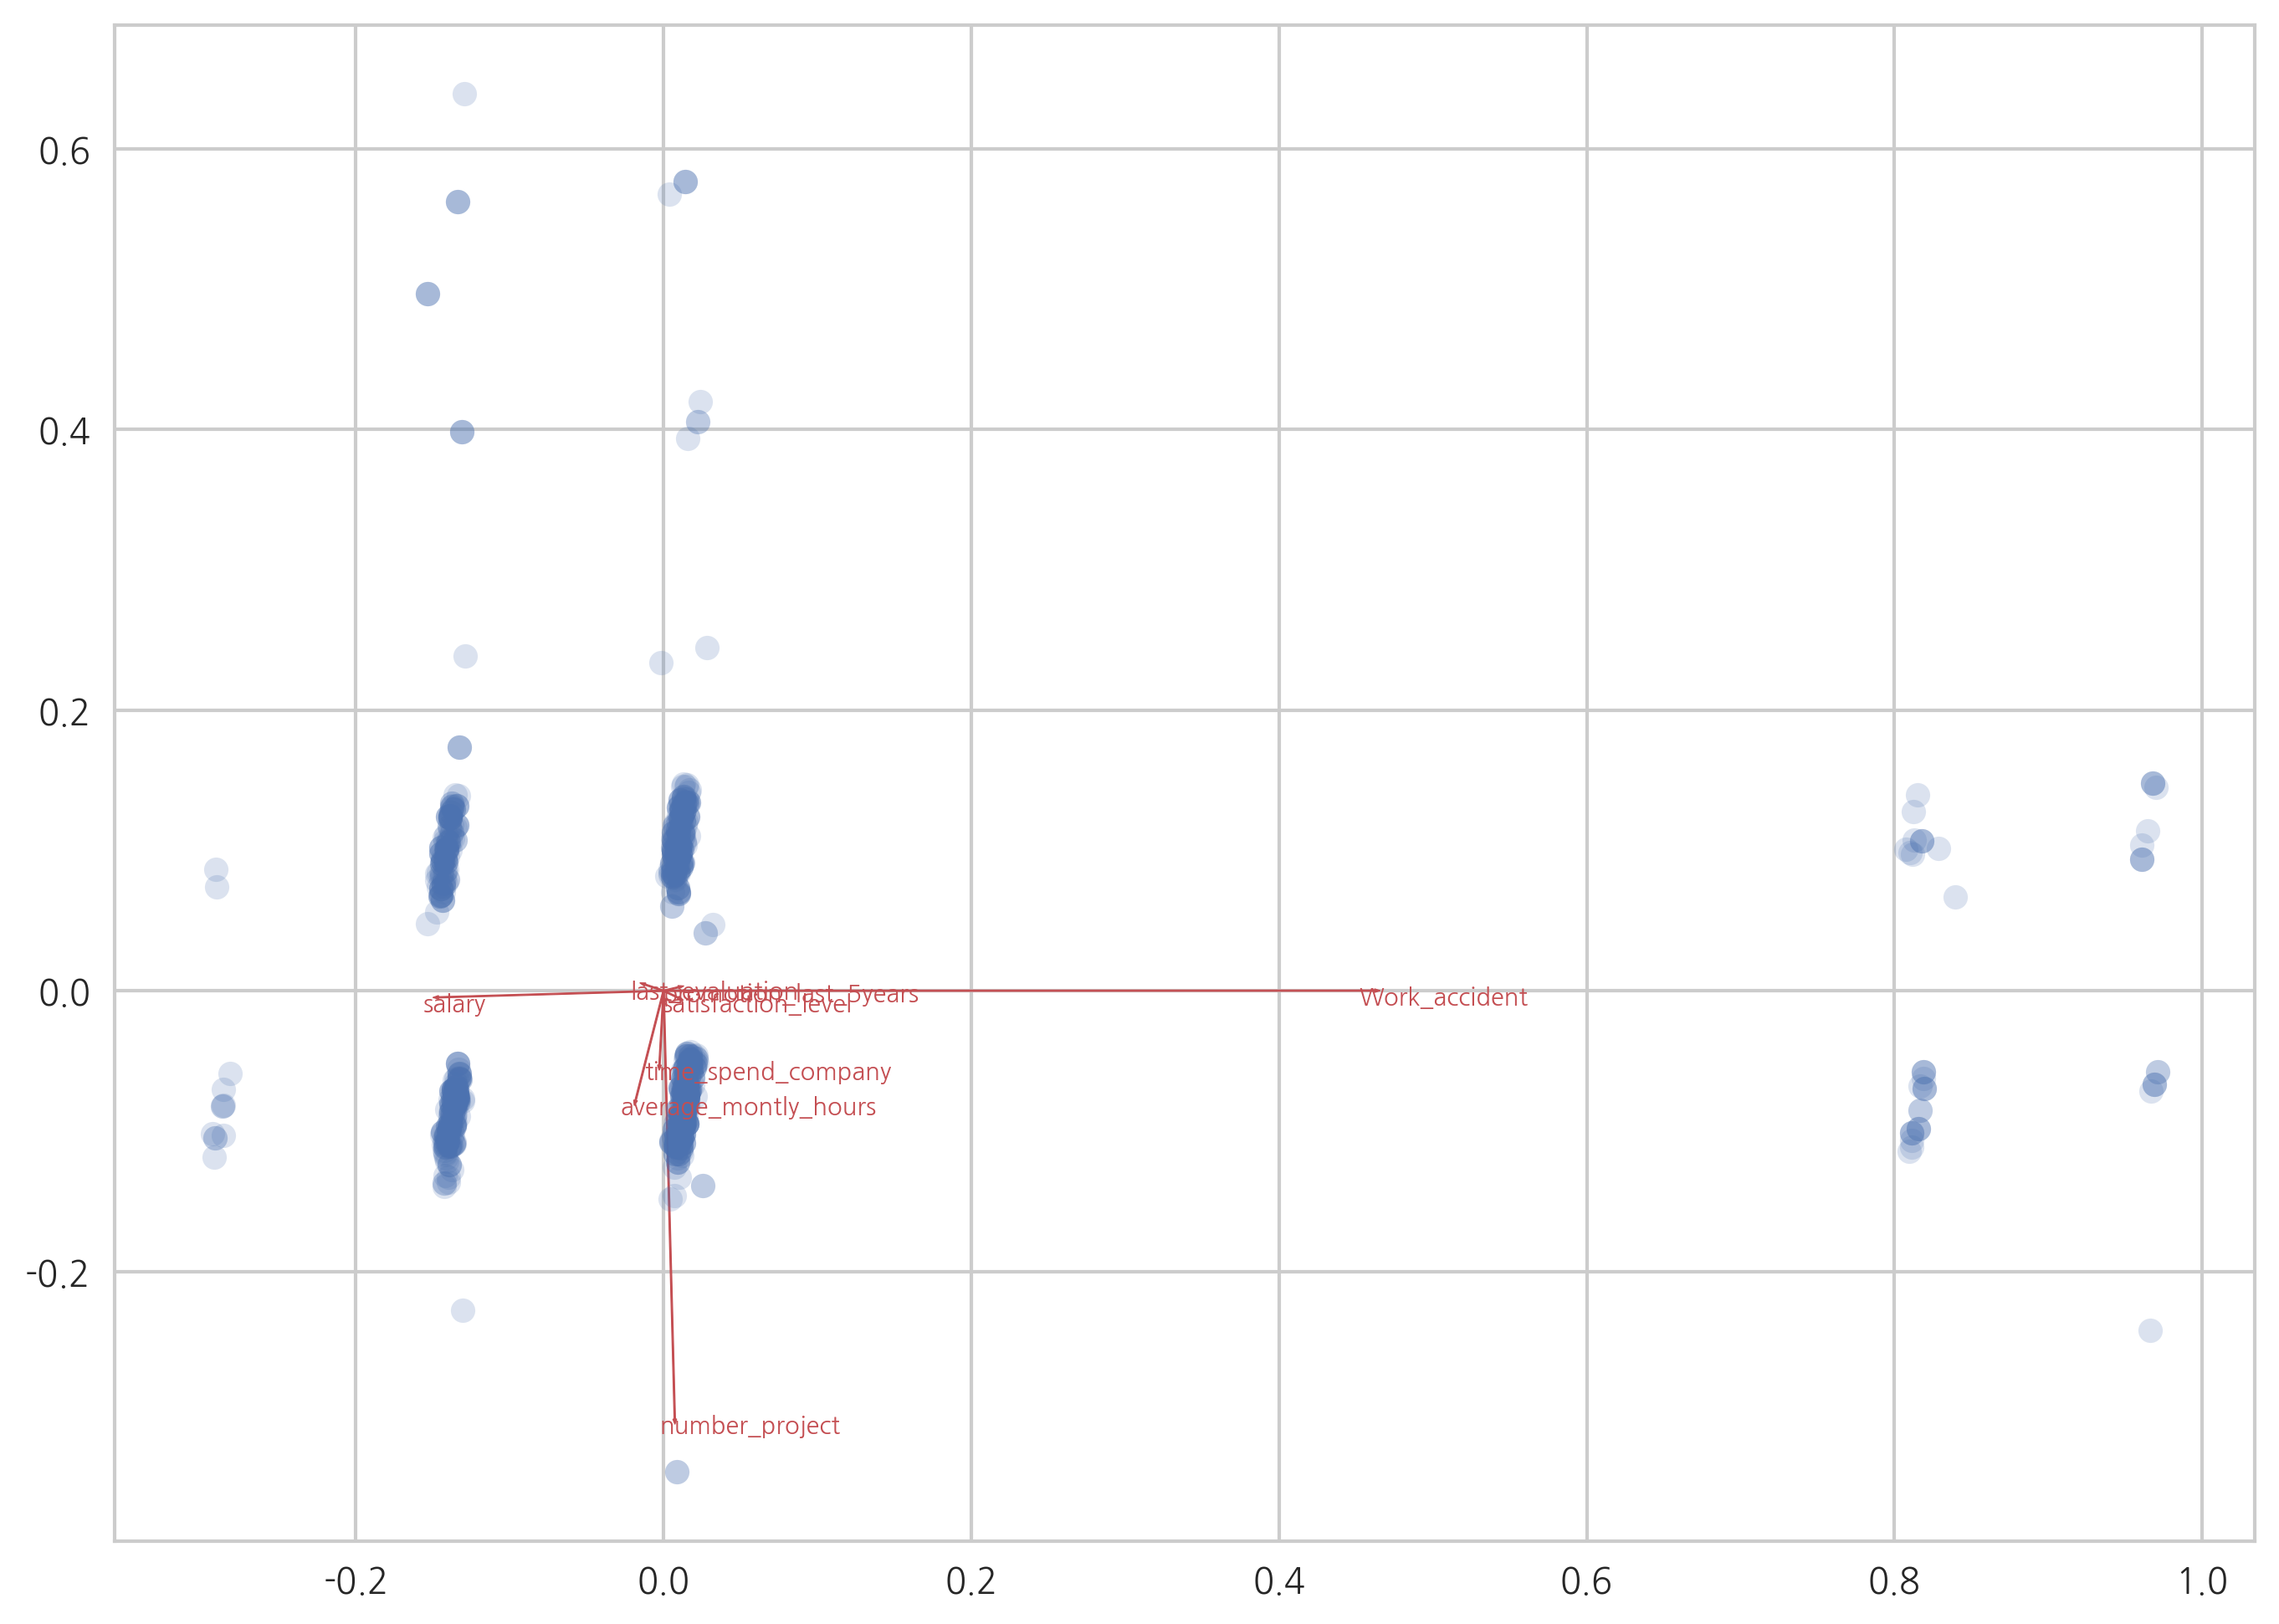

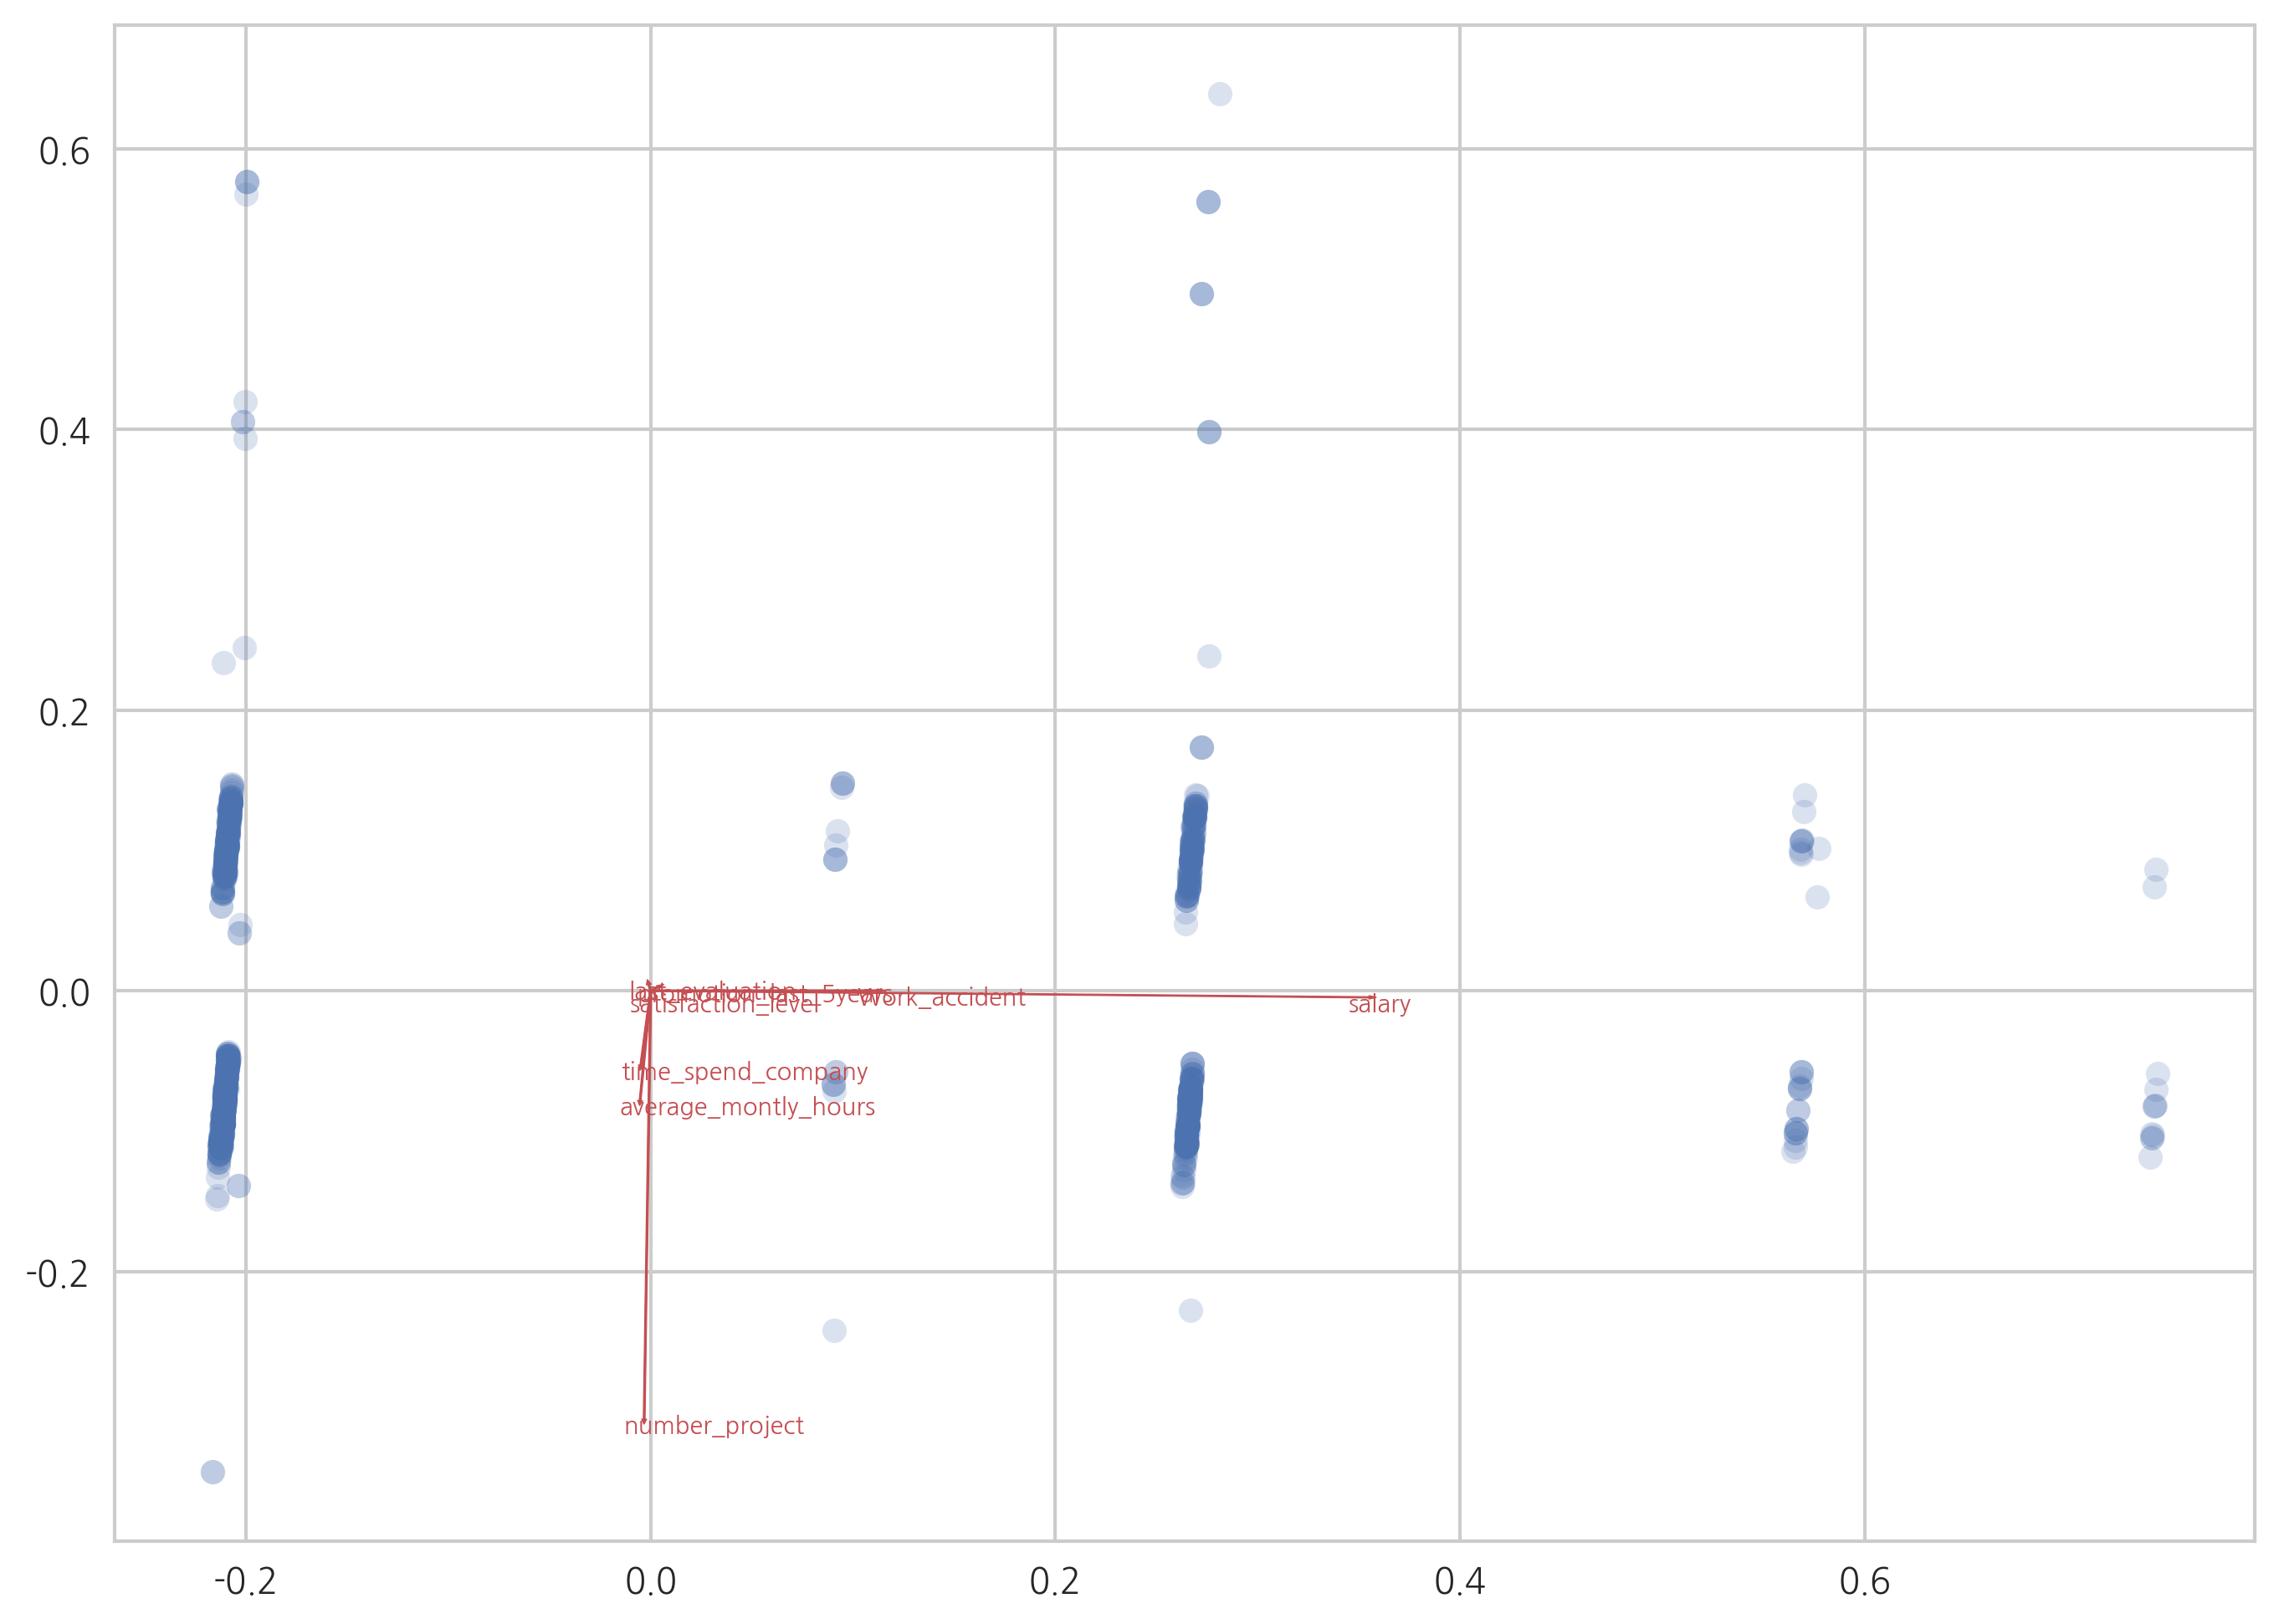

In [38]:
PCA_biplot(df_cluster_1,0,1)
PCA_biplot(df_cluster_1,1,2)
PCA_biplot(df_cluster_1,0,2)

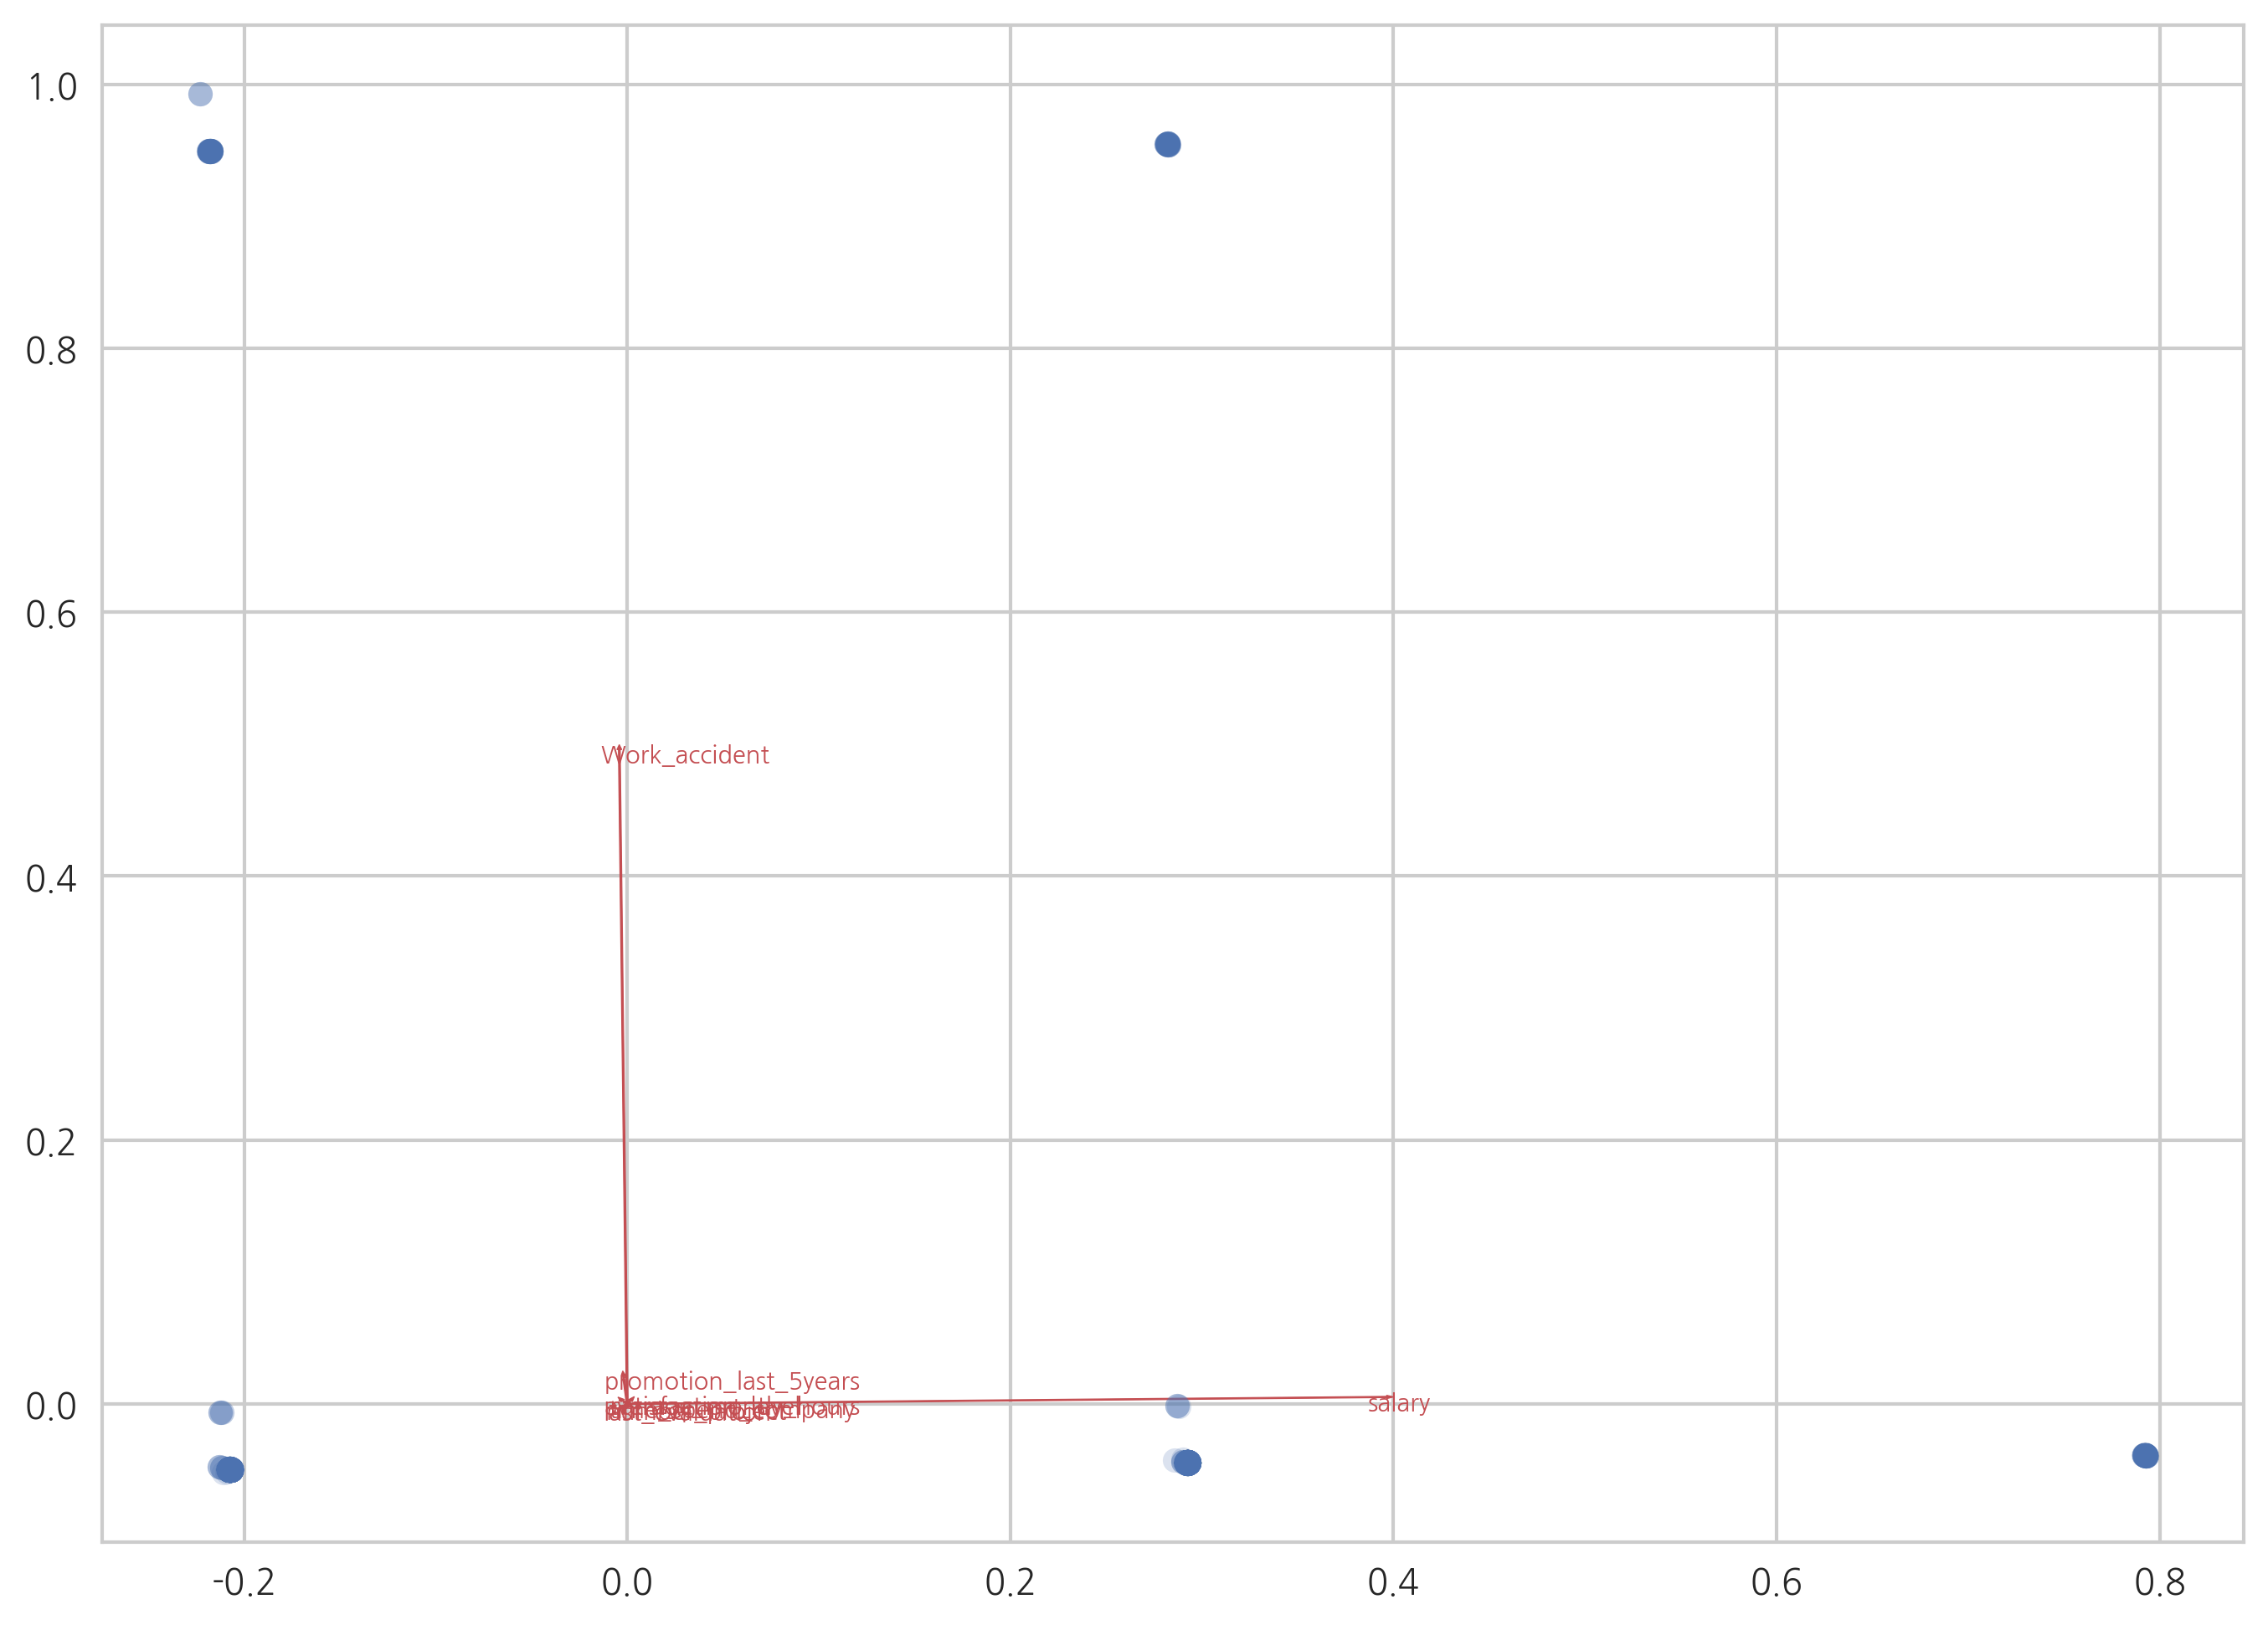

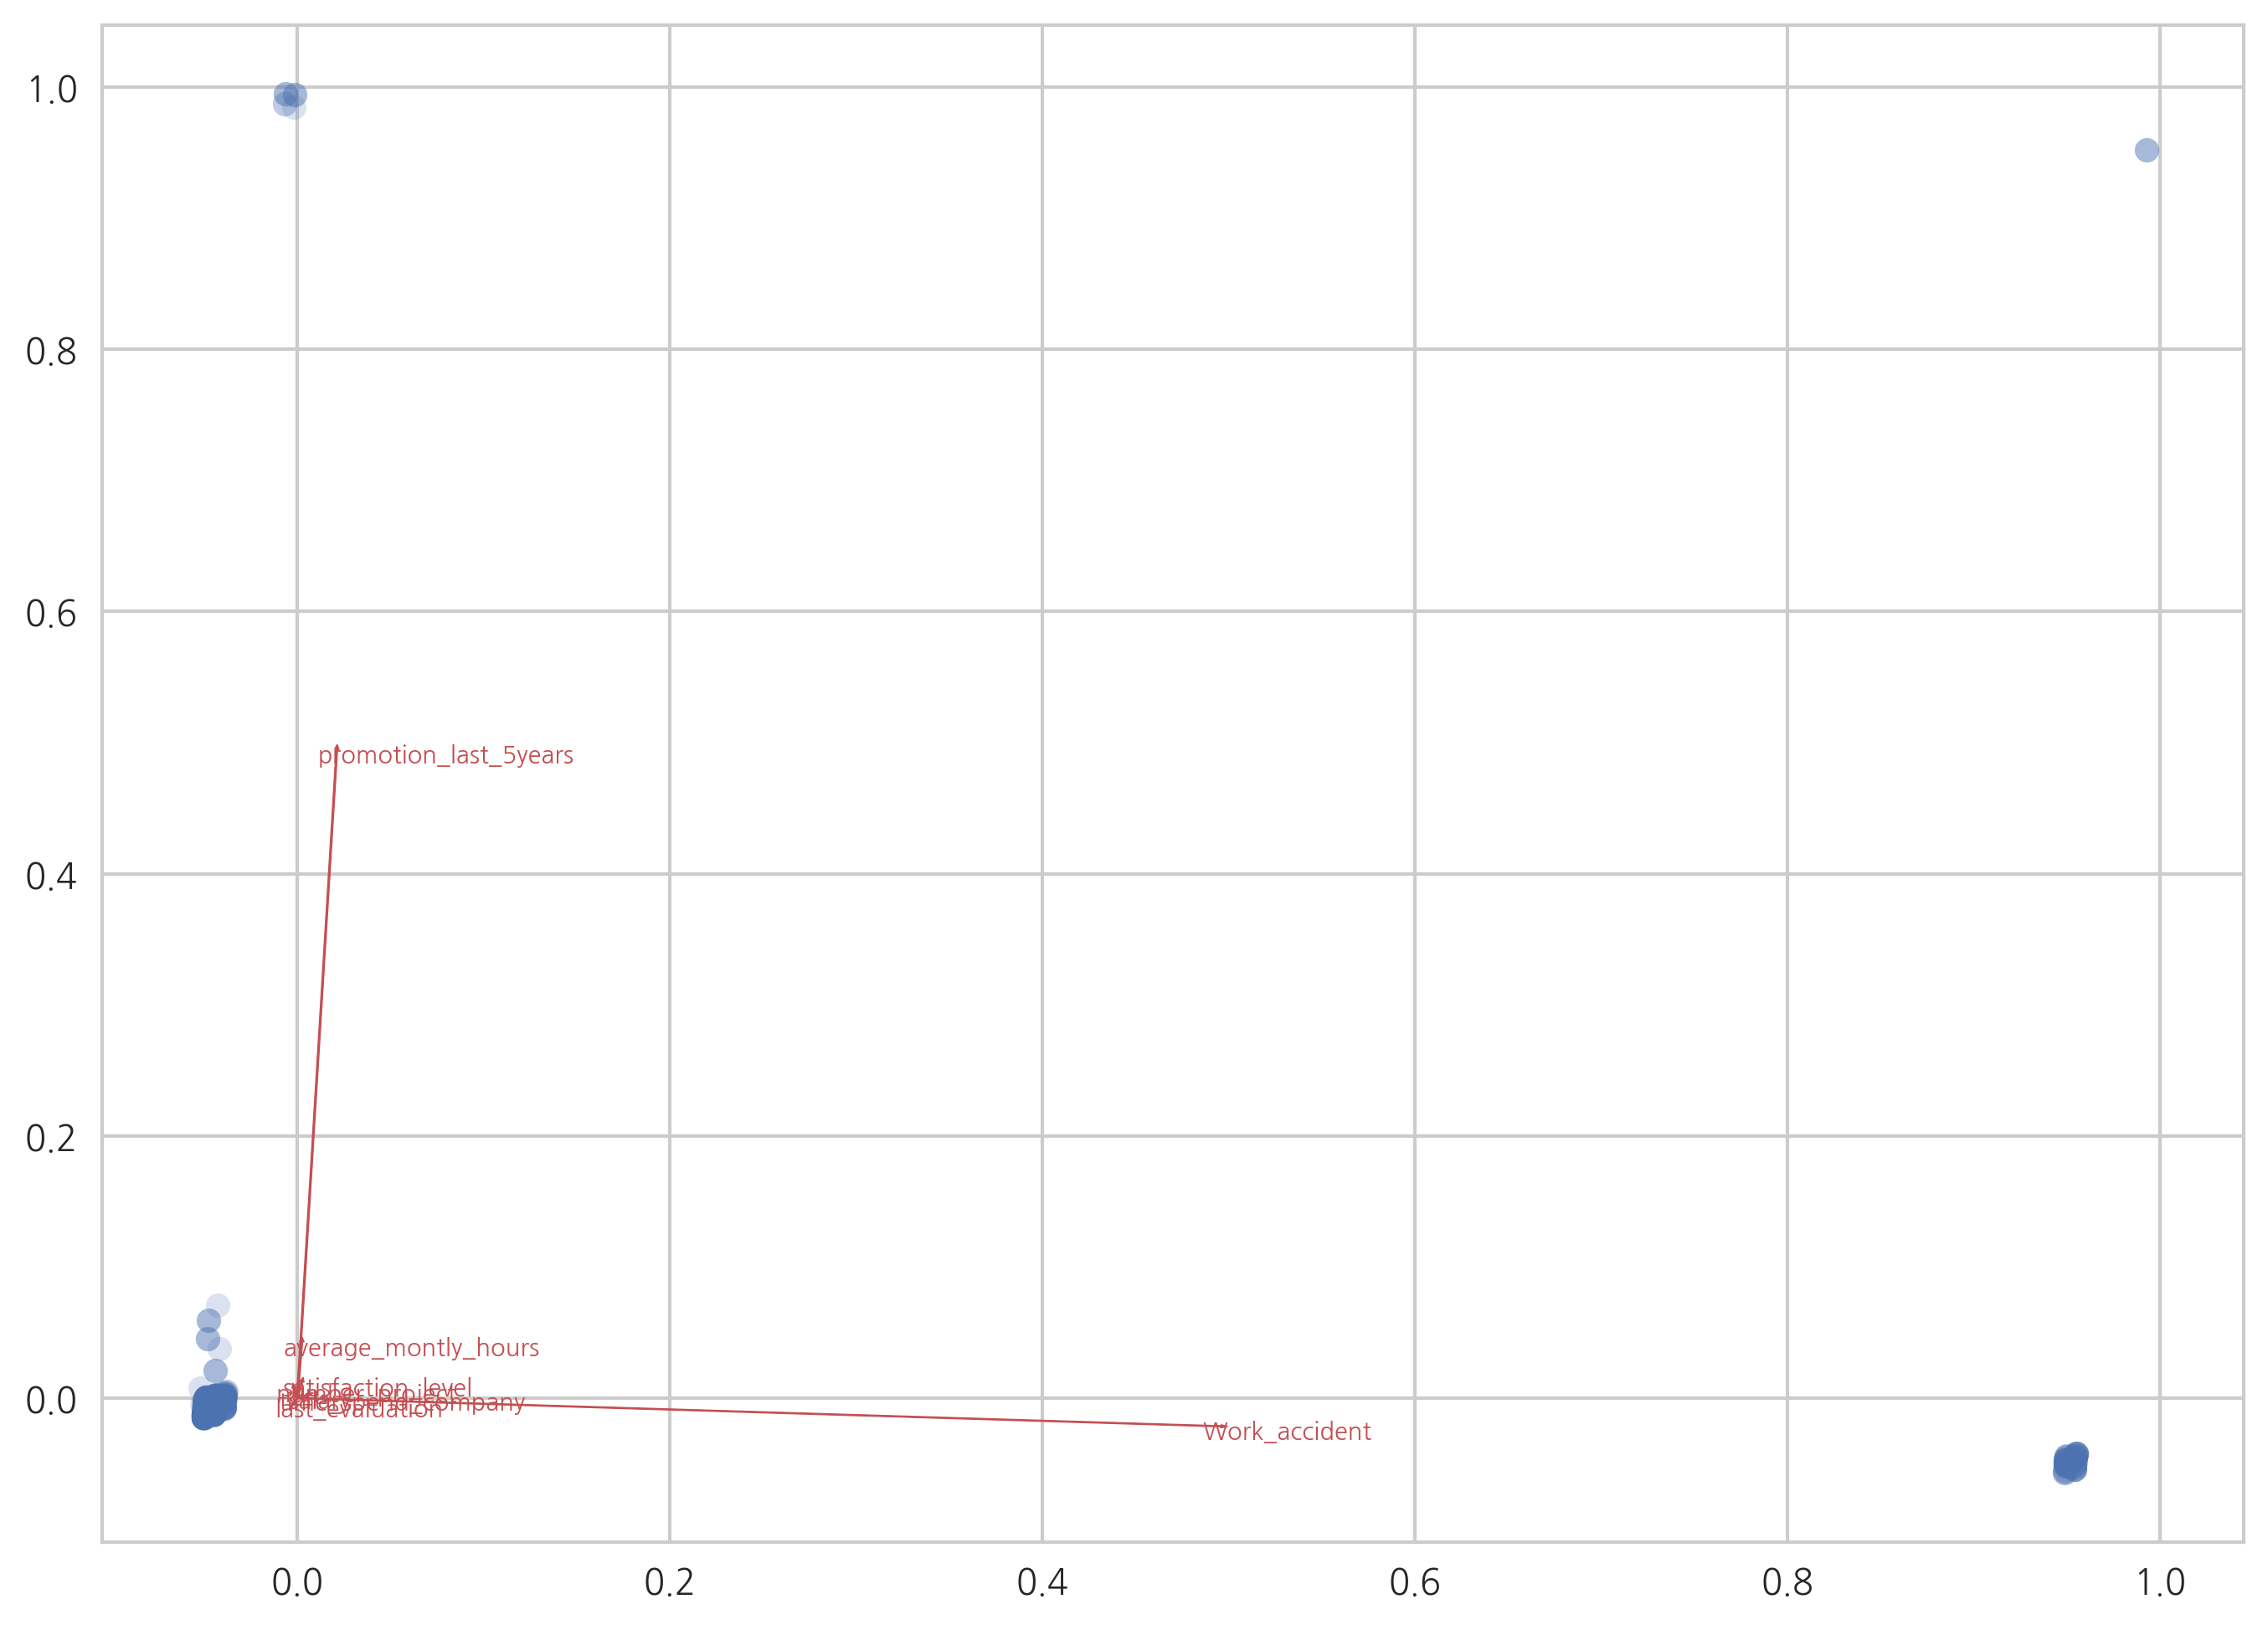

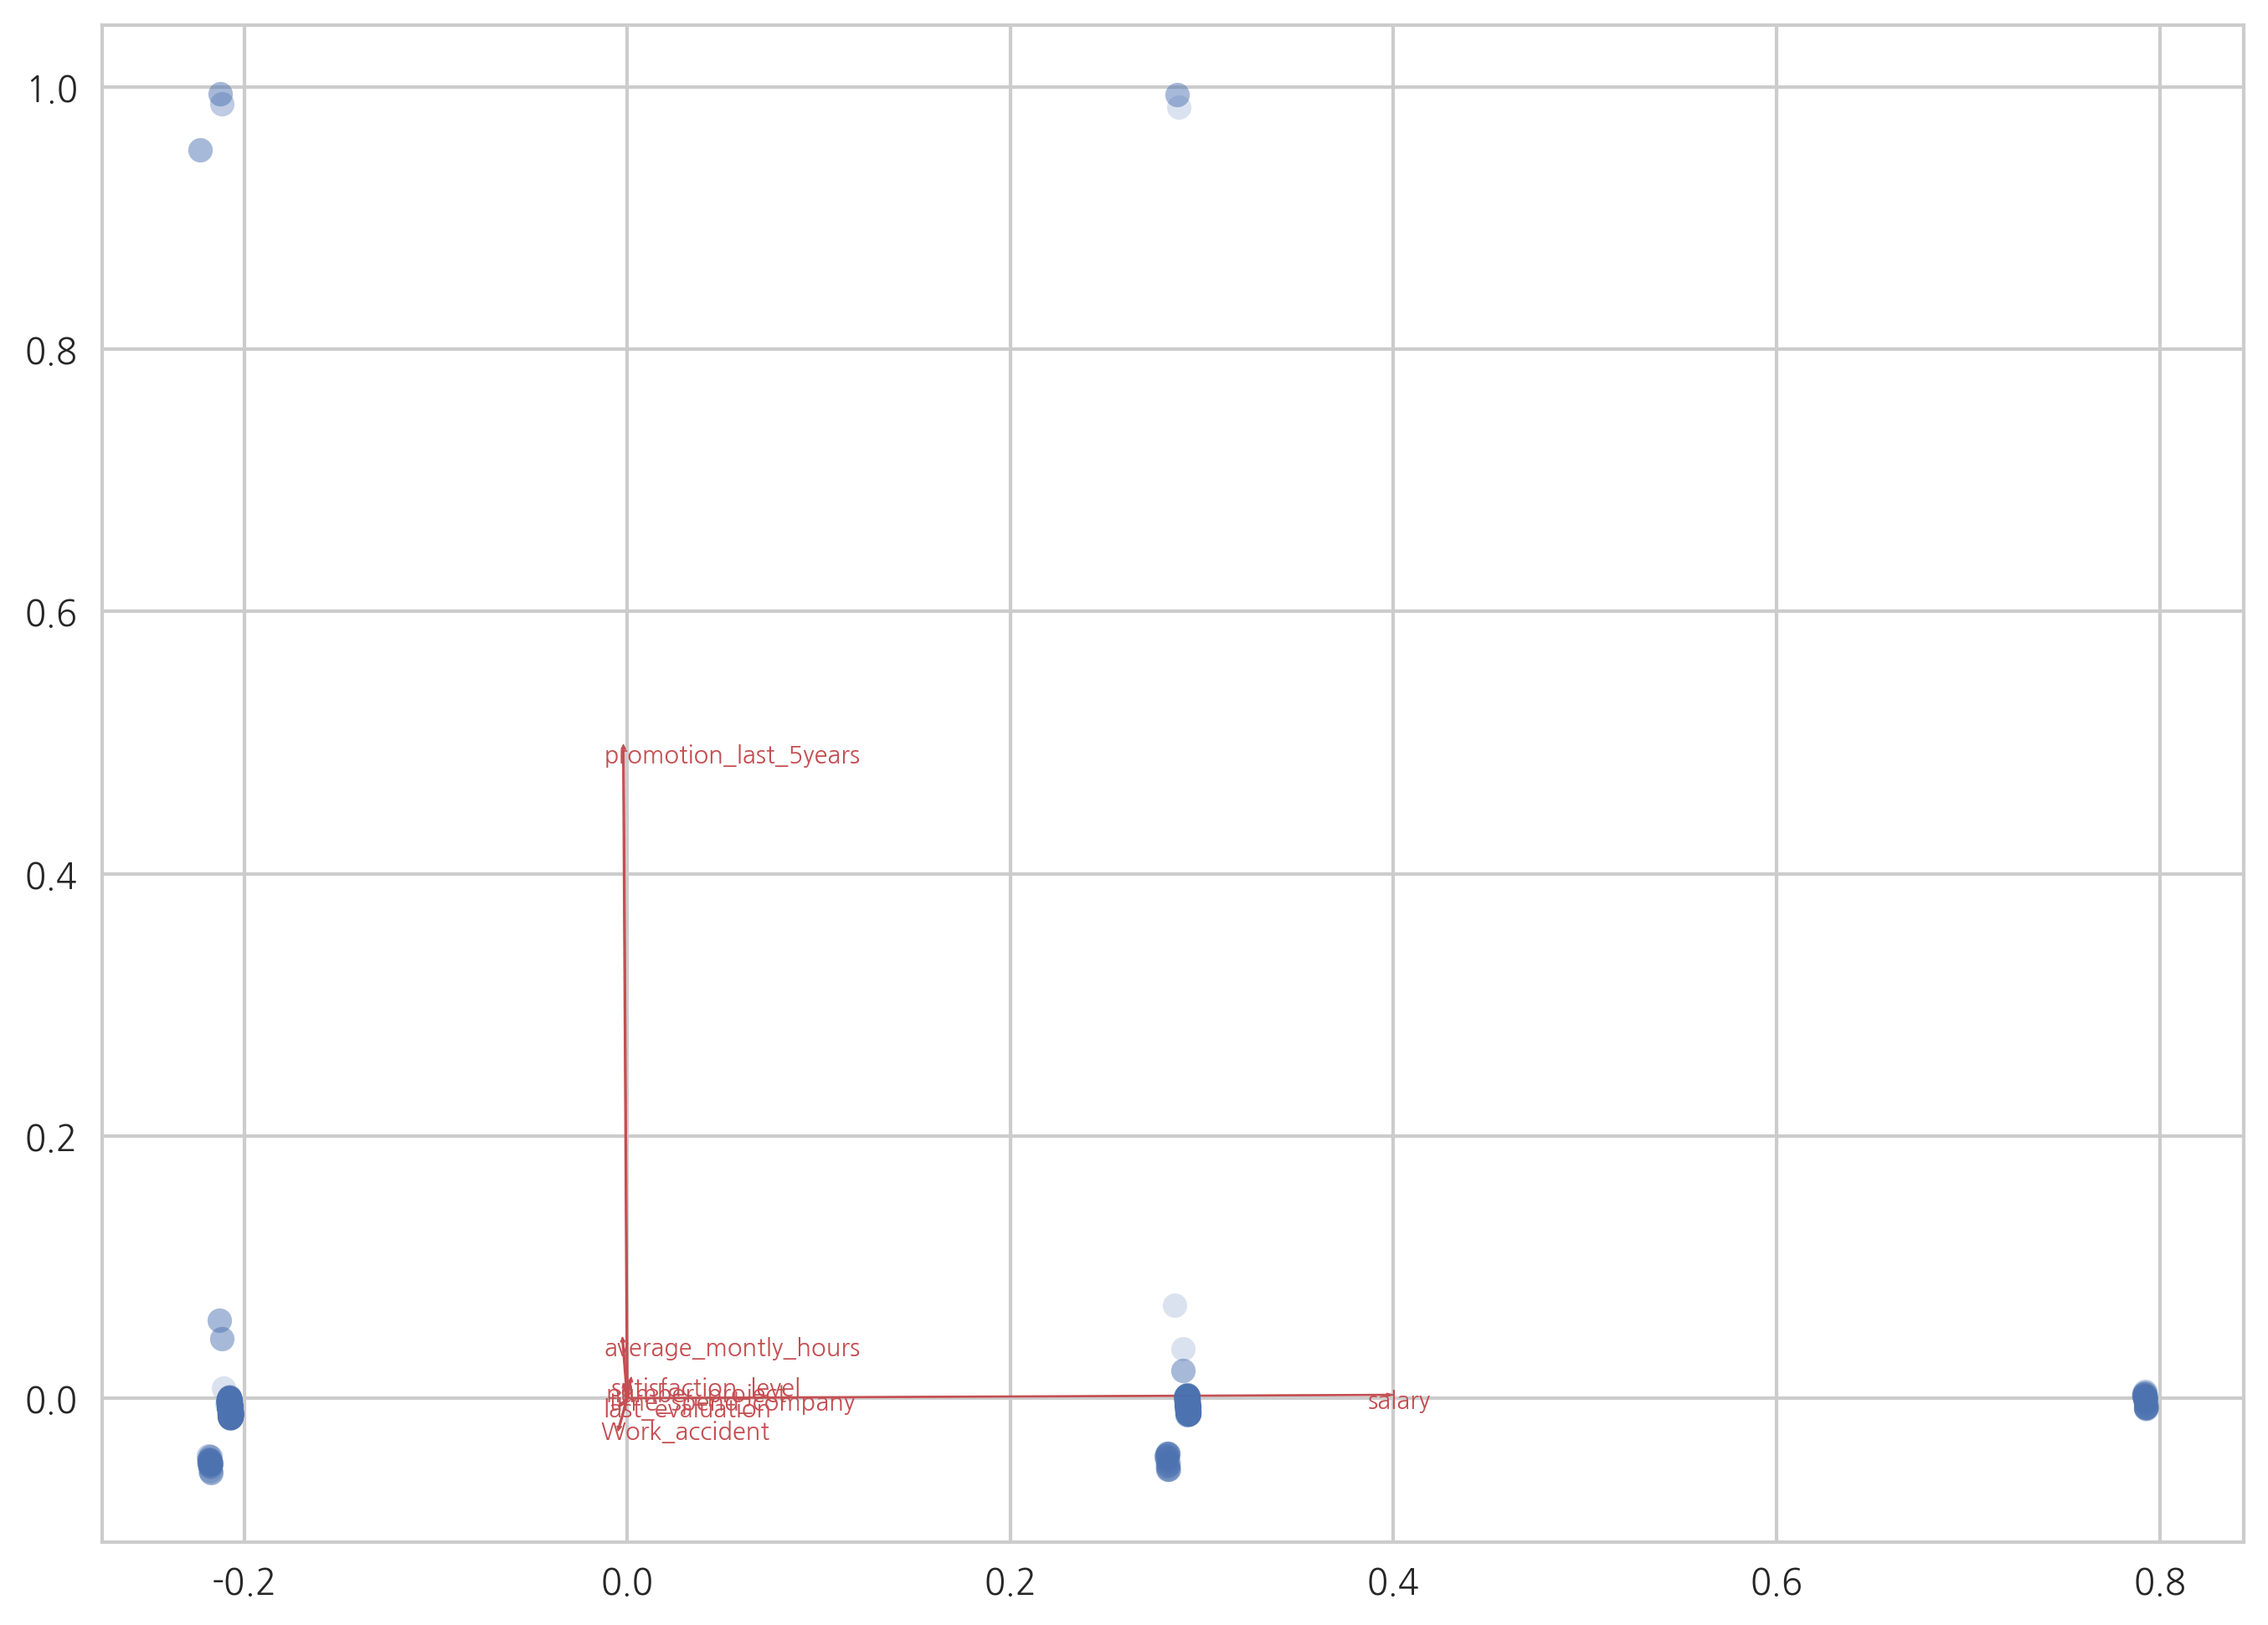

In [40]:
PCA_biplot(df_cluster_2,0,1)
PCA_biplot(df_cluster_2,1,2)
PCA_biplot(df_cluster_2,0,2)

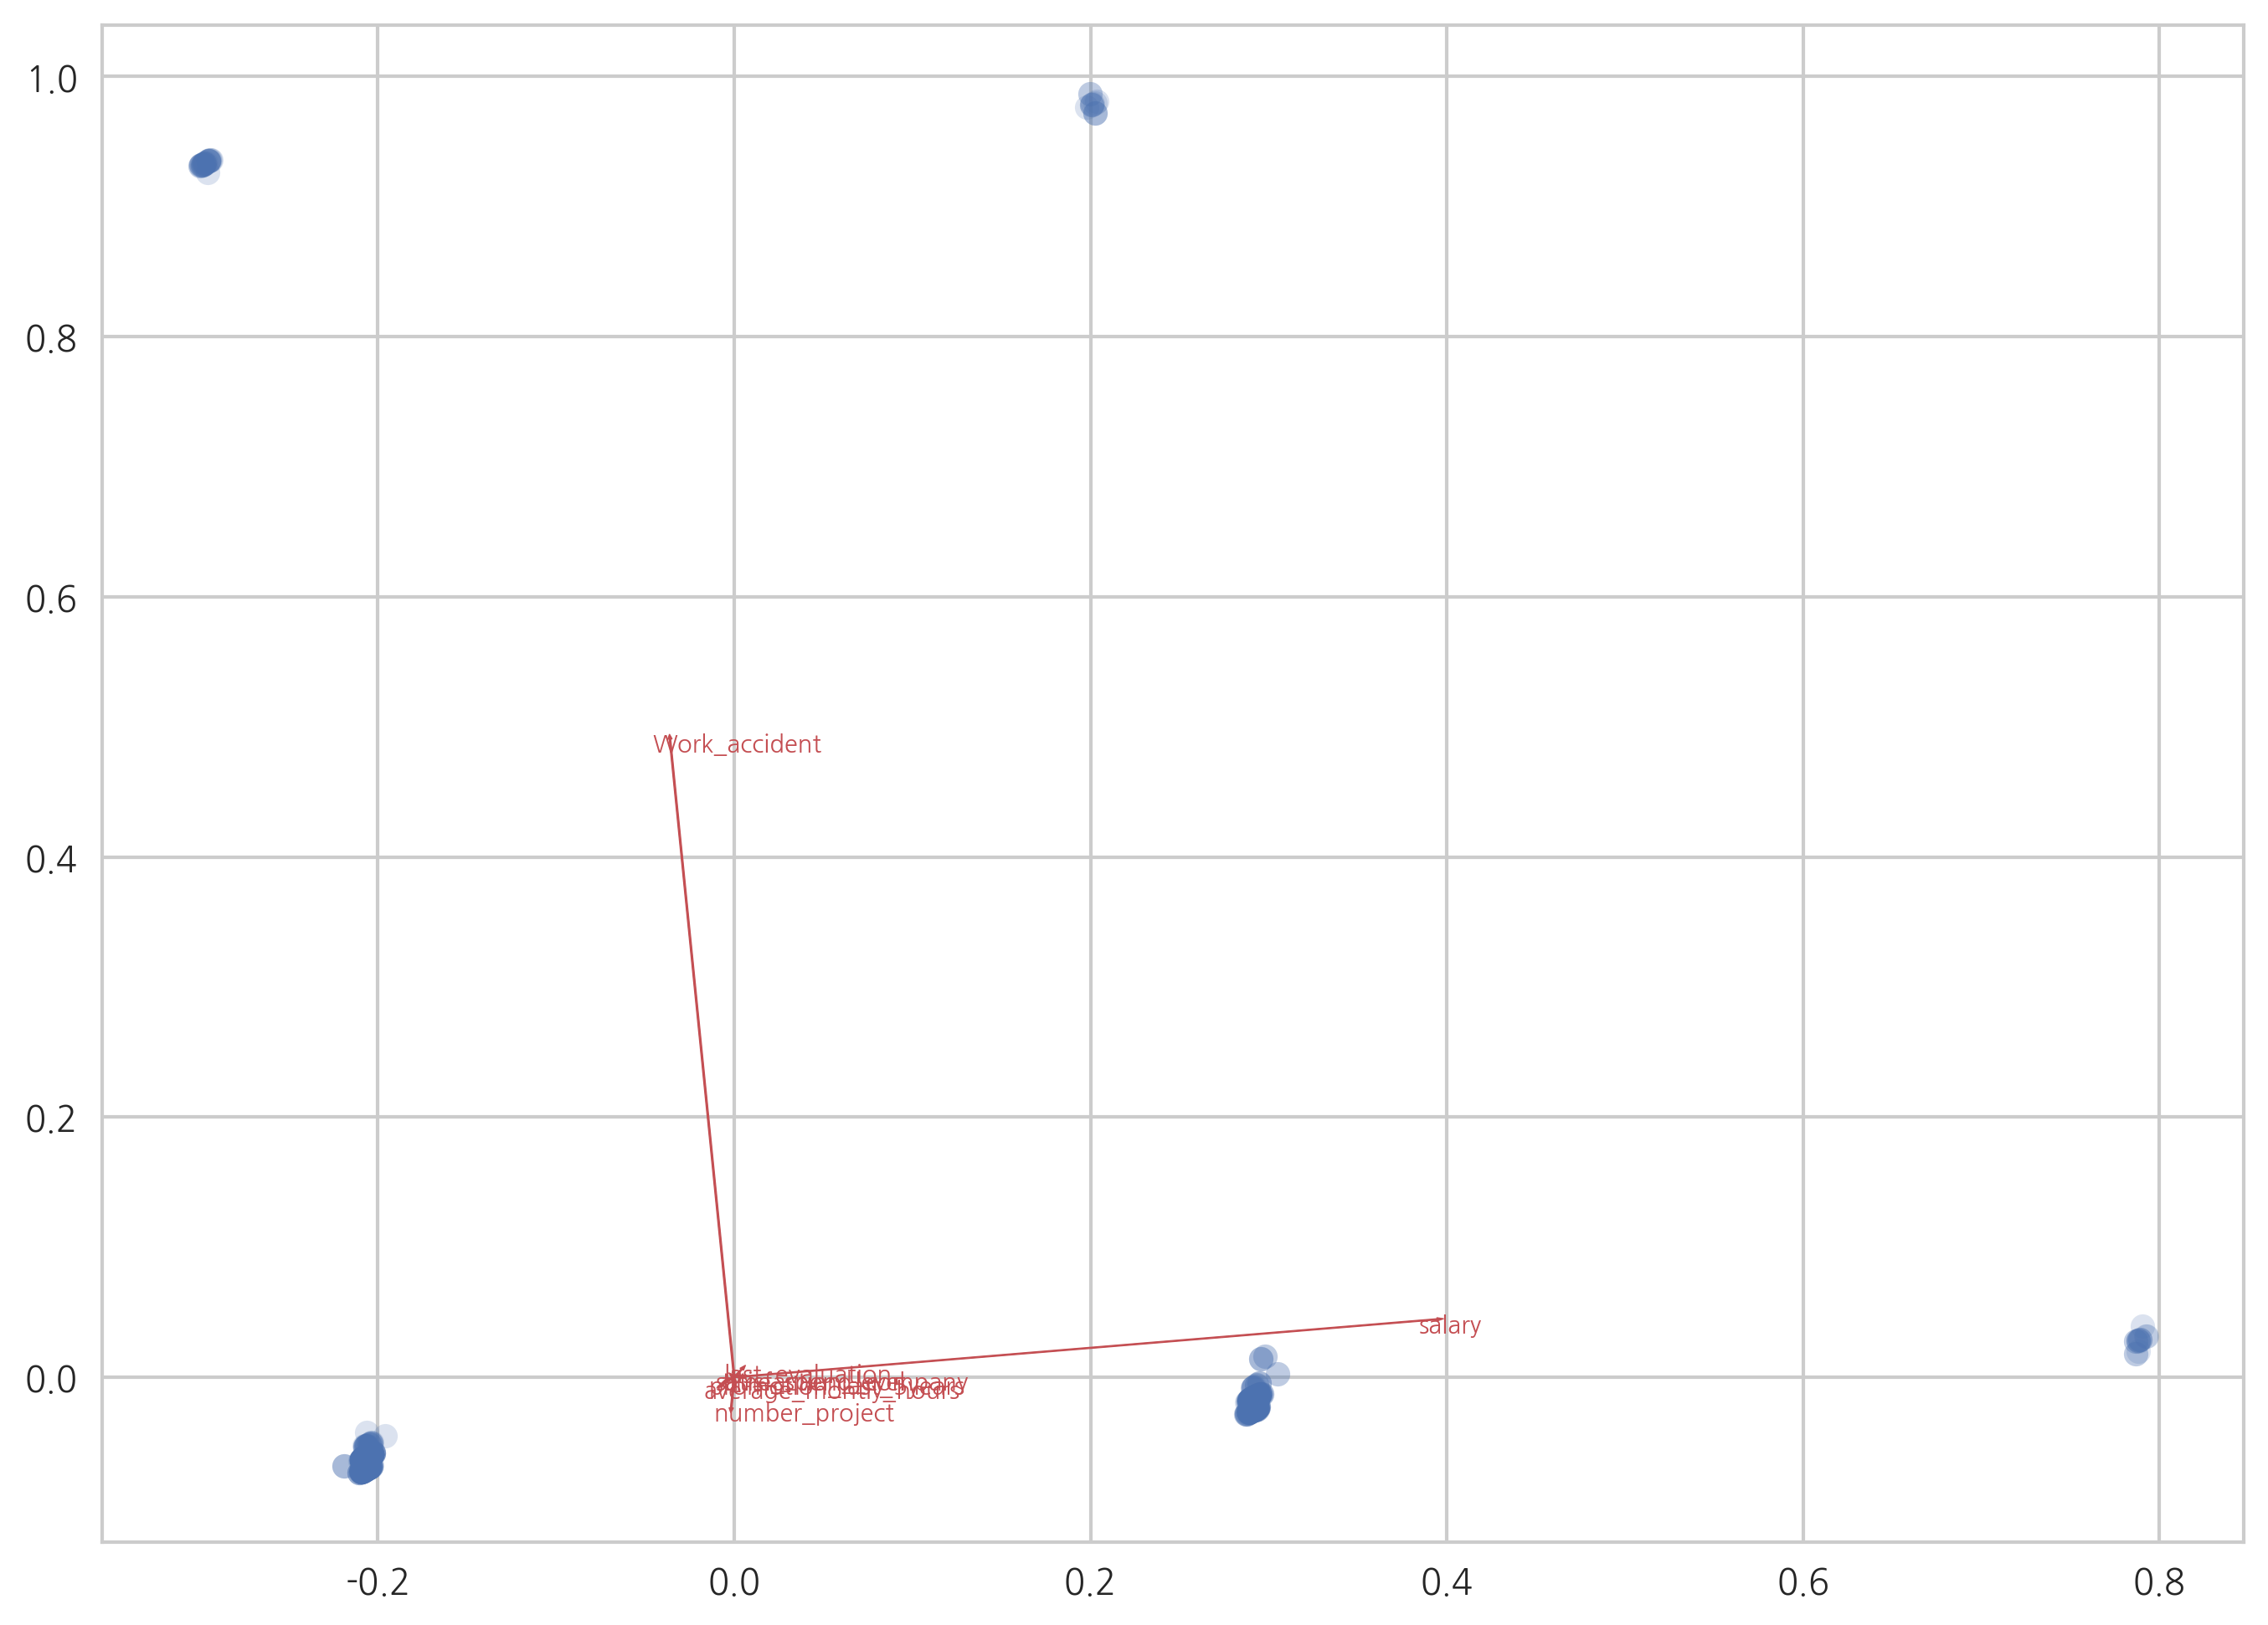

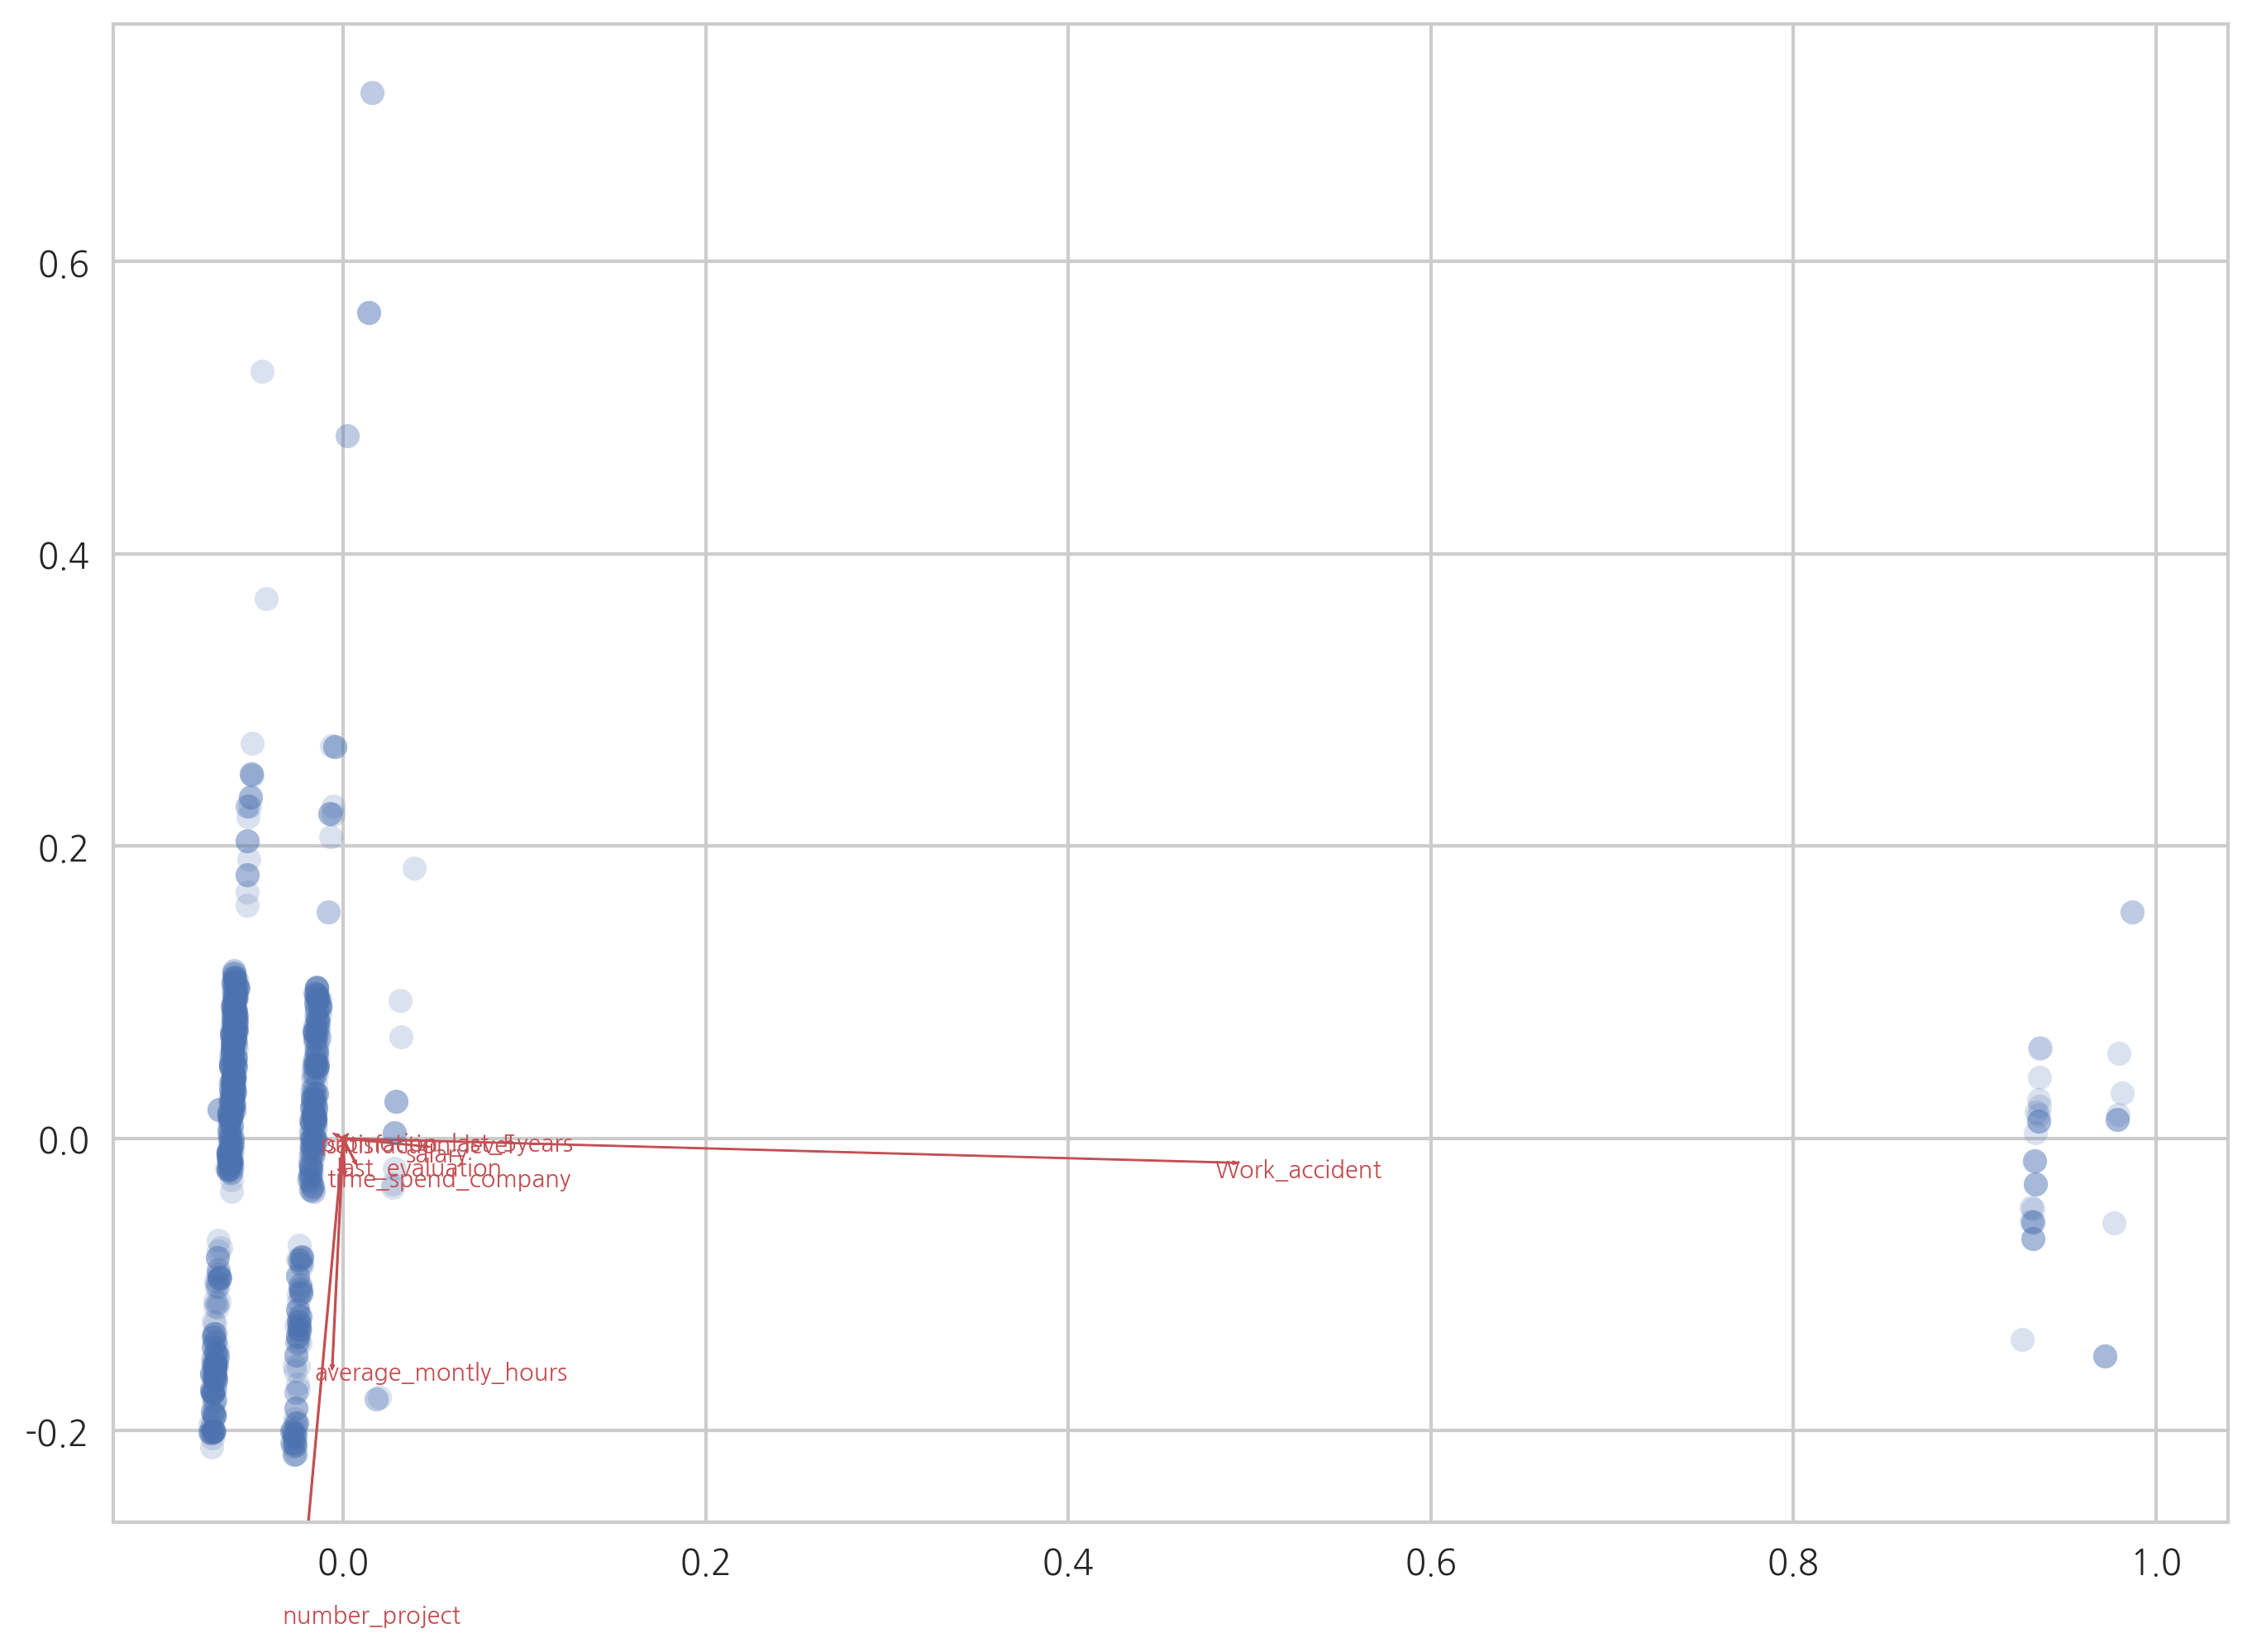

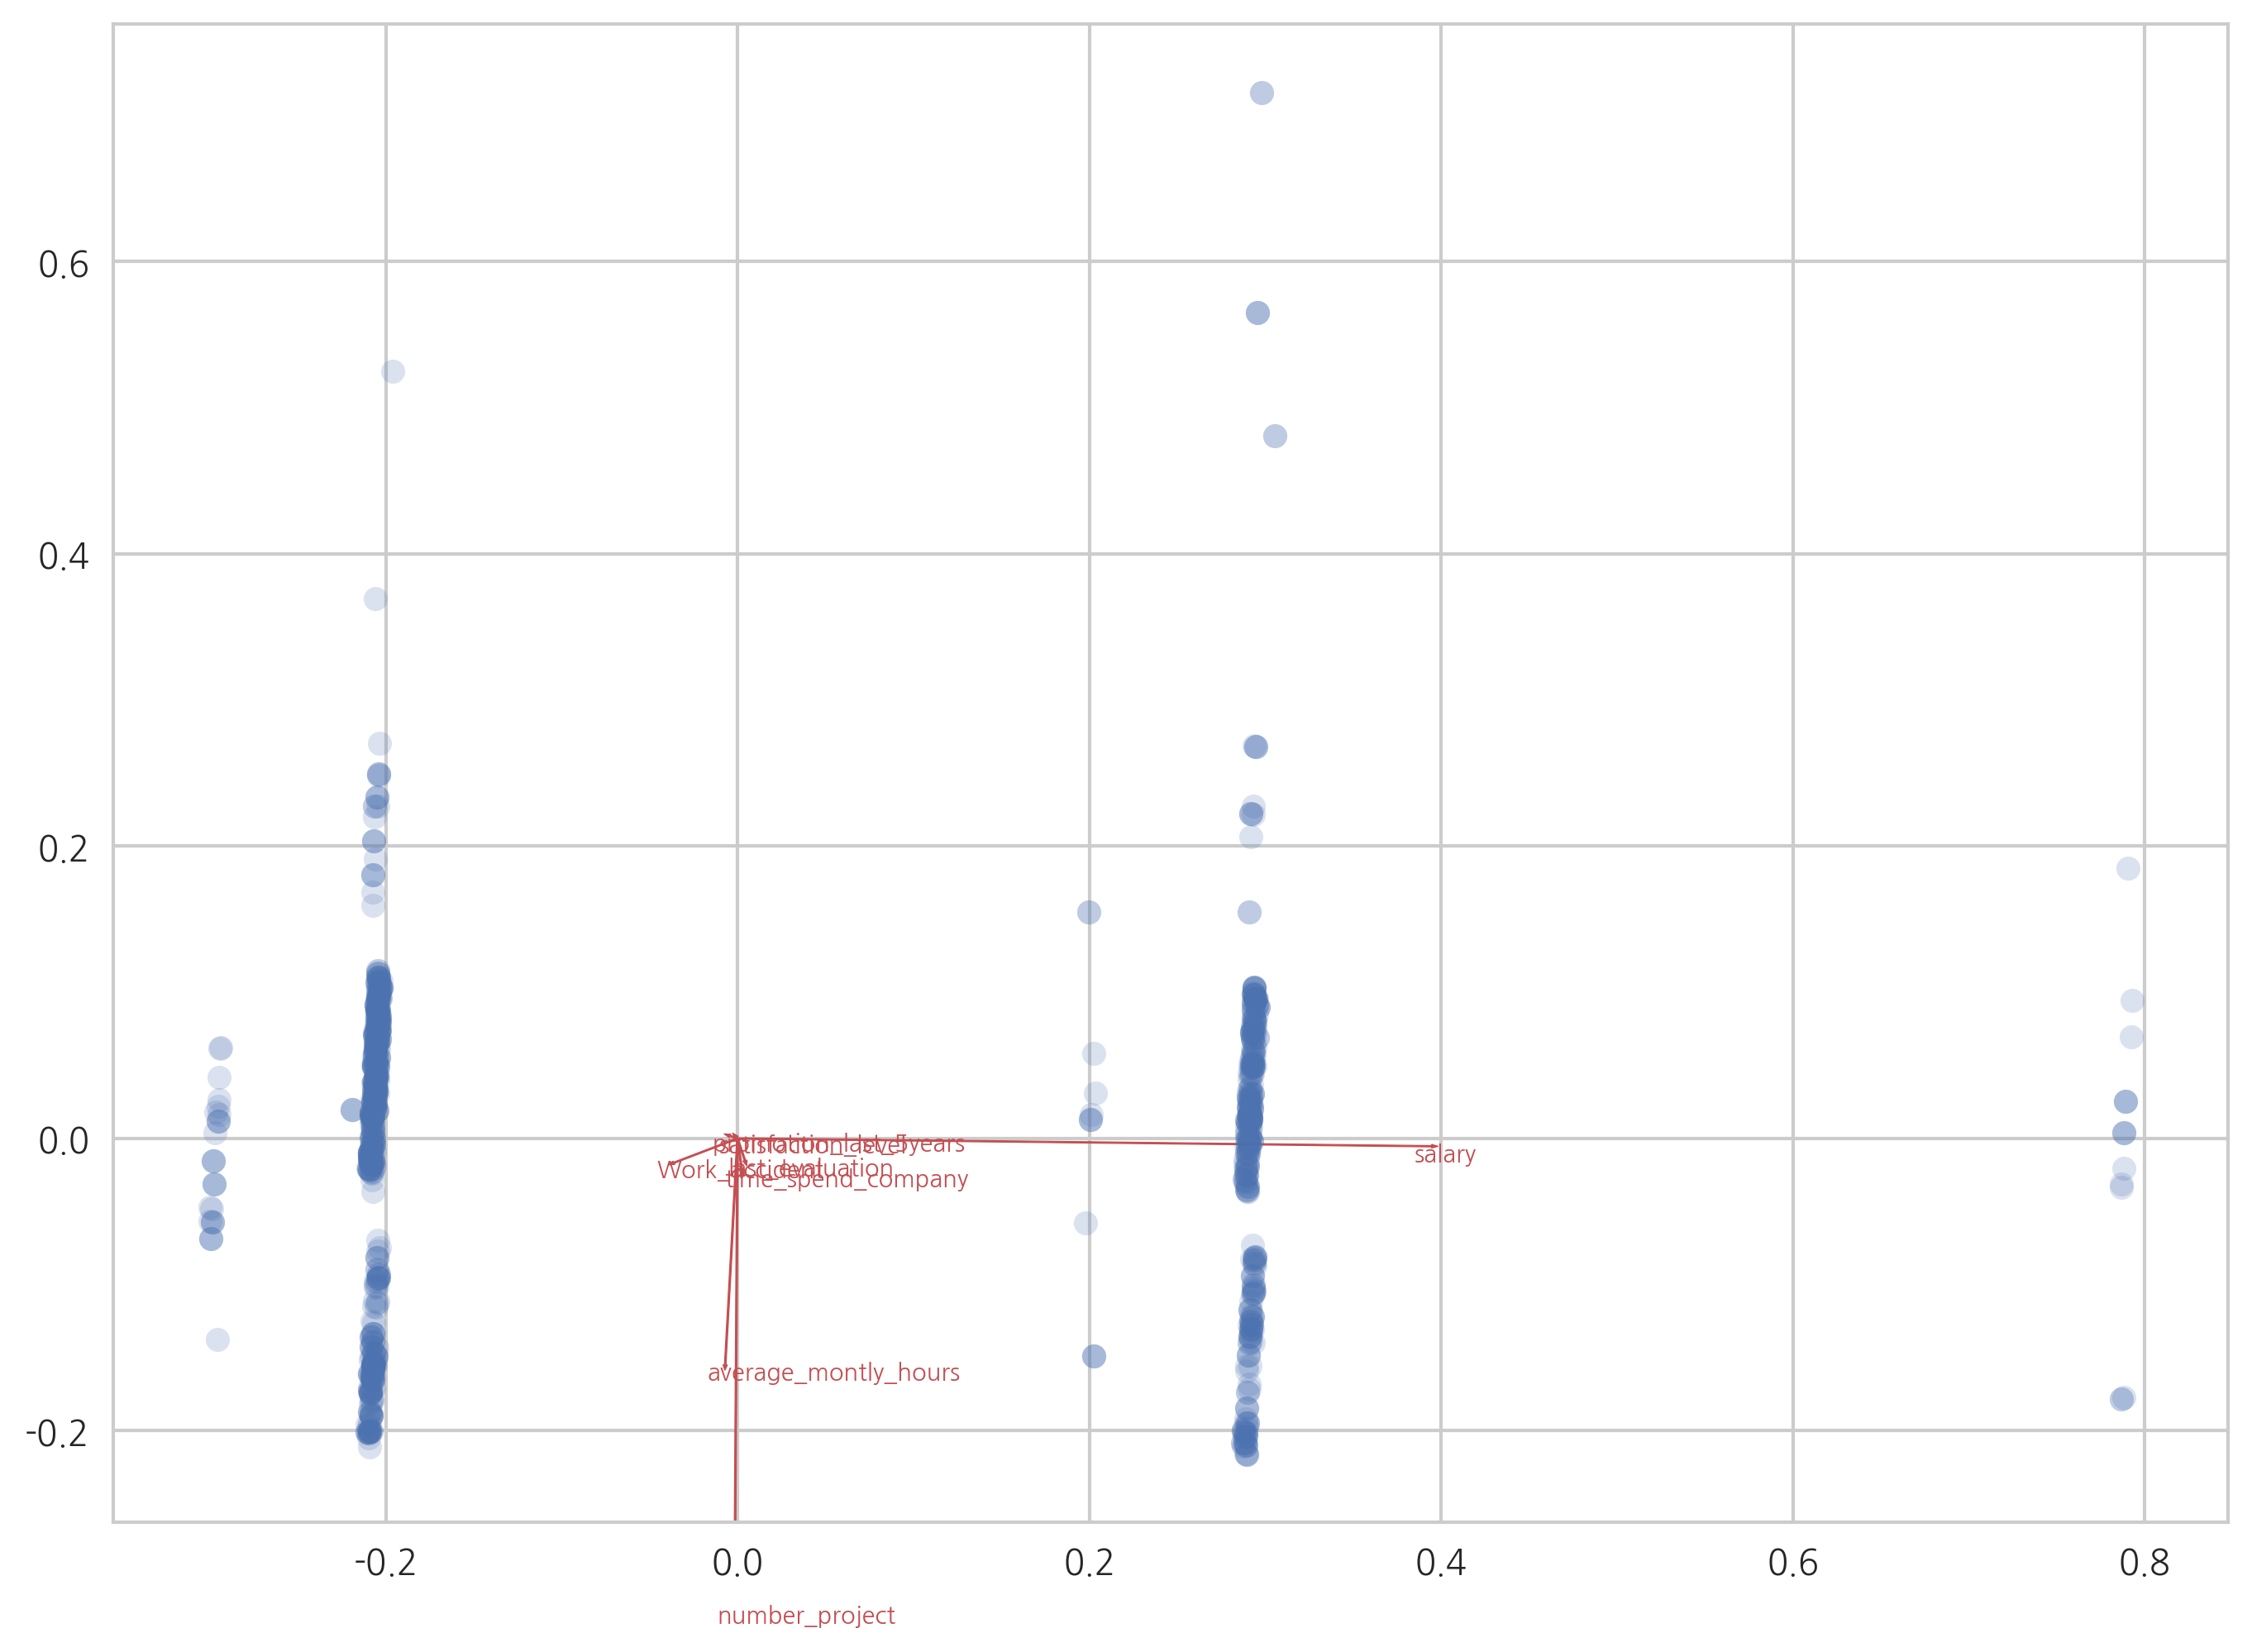

In [39]:
PCA_biplot(df_cluster_3,0,1)
PCA_biplot(df_cluster_3,1,2)
PCA_biplot(df_cluster_3,0,2)

**number_project, average_montly_hours,time_spend_company**등이 cluster_1, cluster_3에서 크게 그려지고 있으나, cluster_2에서는 
**승진여부**가 크게 그려지고 있다. 즉 cluster_2에서는 **number_project, average_montly_hours,time_spend_company**등이 유사한 집단인 것을 알 수 있다. 이하에서는 클러스터 별 구분이 되는 요소인 number_project, average_montly_hours,time_spend_company에 대해 **시각화** 해보도록 하겠다.

### 각 cluster 별 원인 진단(위에서 추론한 것을 시각해보기)

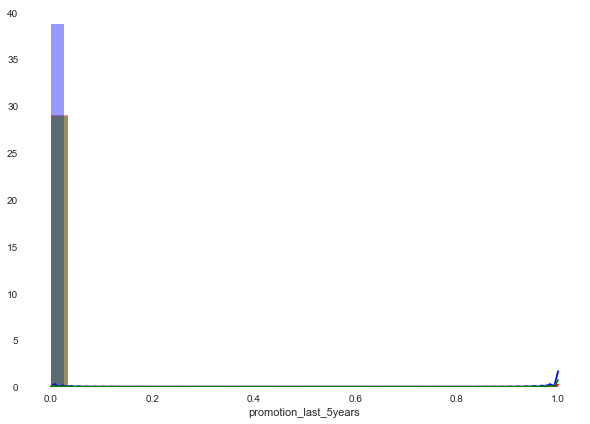

In [4]:
fig= plt.figure(num=1, figsize=(10,7))
ax = fig.add_subplot(111) 
ax.set_facecolor('white')

sns.distplot(df_cluster_1.promotion_last_5years, color = 'r')
sns.distplot(df_cluster_2.promotion_last_5years, color ='b')
sns.distplot(df_cluster_3.promotion_last_5years, color ='g')
plt.show()

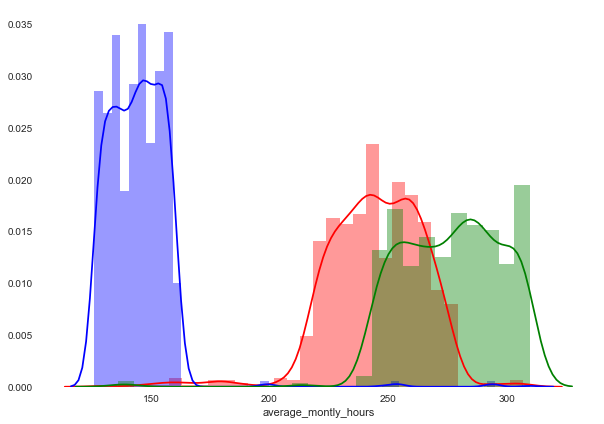

In [5]:
fig= plt.figure(num=1, figsize=(10,7))
ax = fig.add_subplot(111) 
ax.set_facecolor('white')

sns.distplot(df_cluster_1.average_montly_hours, color = 'r')
sns.distplot(df_cluster_2.average_montly_hours, color ='b')
sns.distplot(df_cluster_3.average_montly_hours, color ='g')
plt.show()

In [ ]:
fig= plt.figure(num=1, figsize=(10,7))
ax = fig.add_subplot(111) 
ax.set_facecolor('white')

sns.distplot(df_cluster_1.number_project, color = 'r')
sns.distplot(df_cluster_2.number_project, color ='b')
sns.distplot(df_cluster_3.number_project, color ='g')
plt.show()

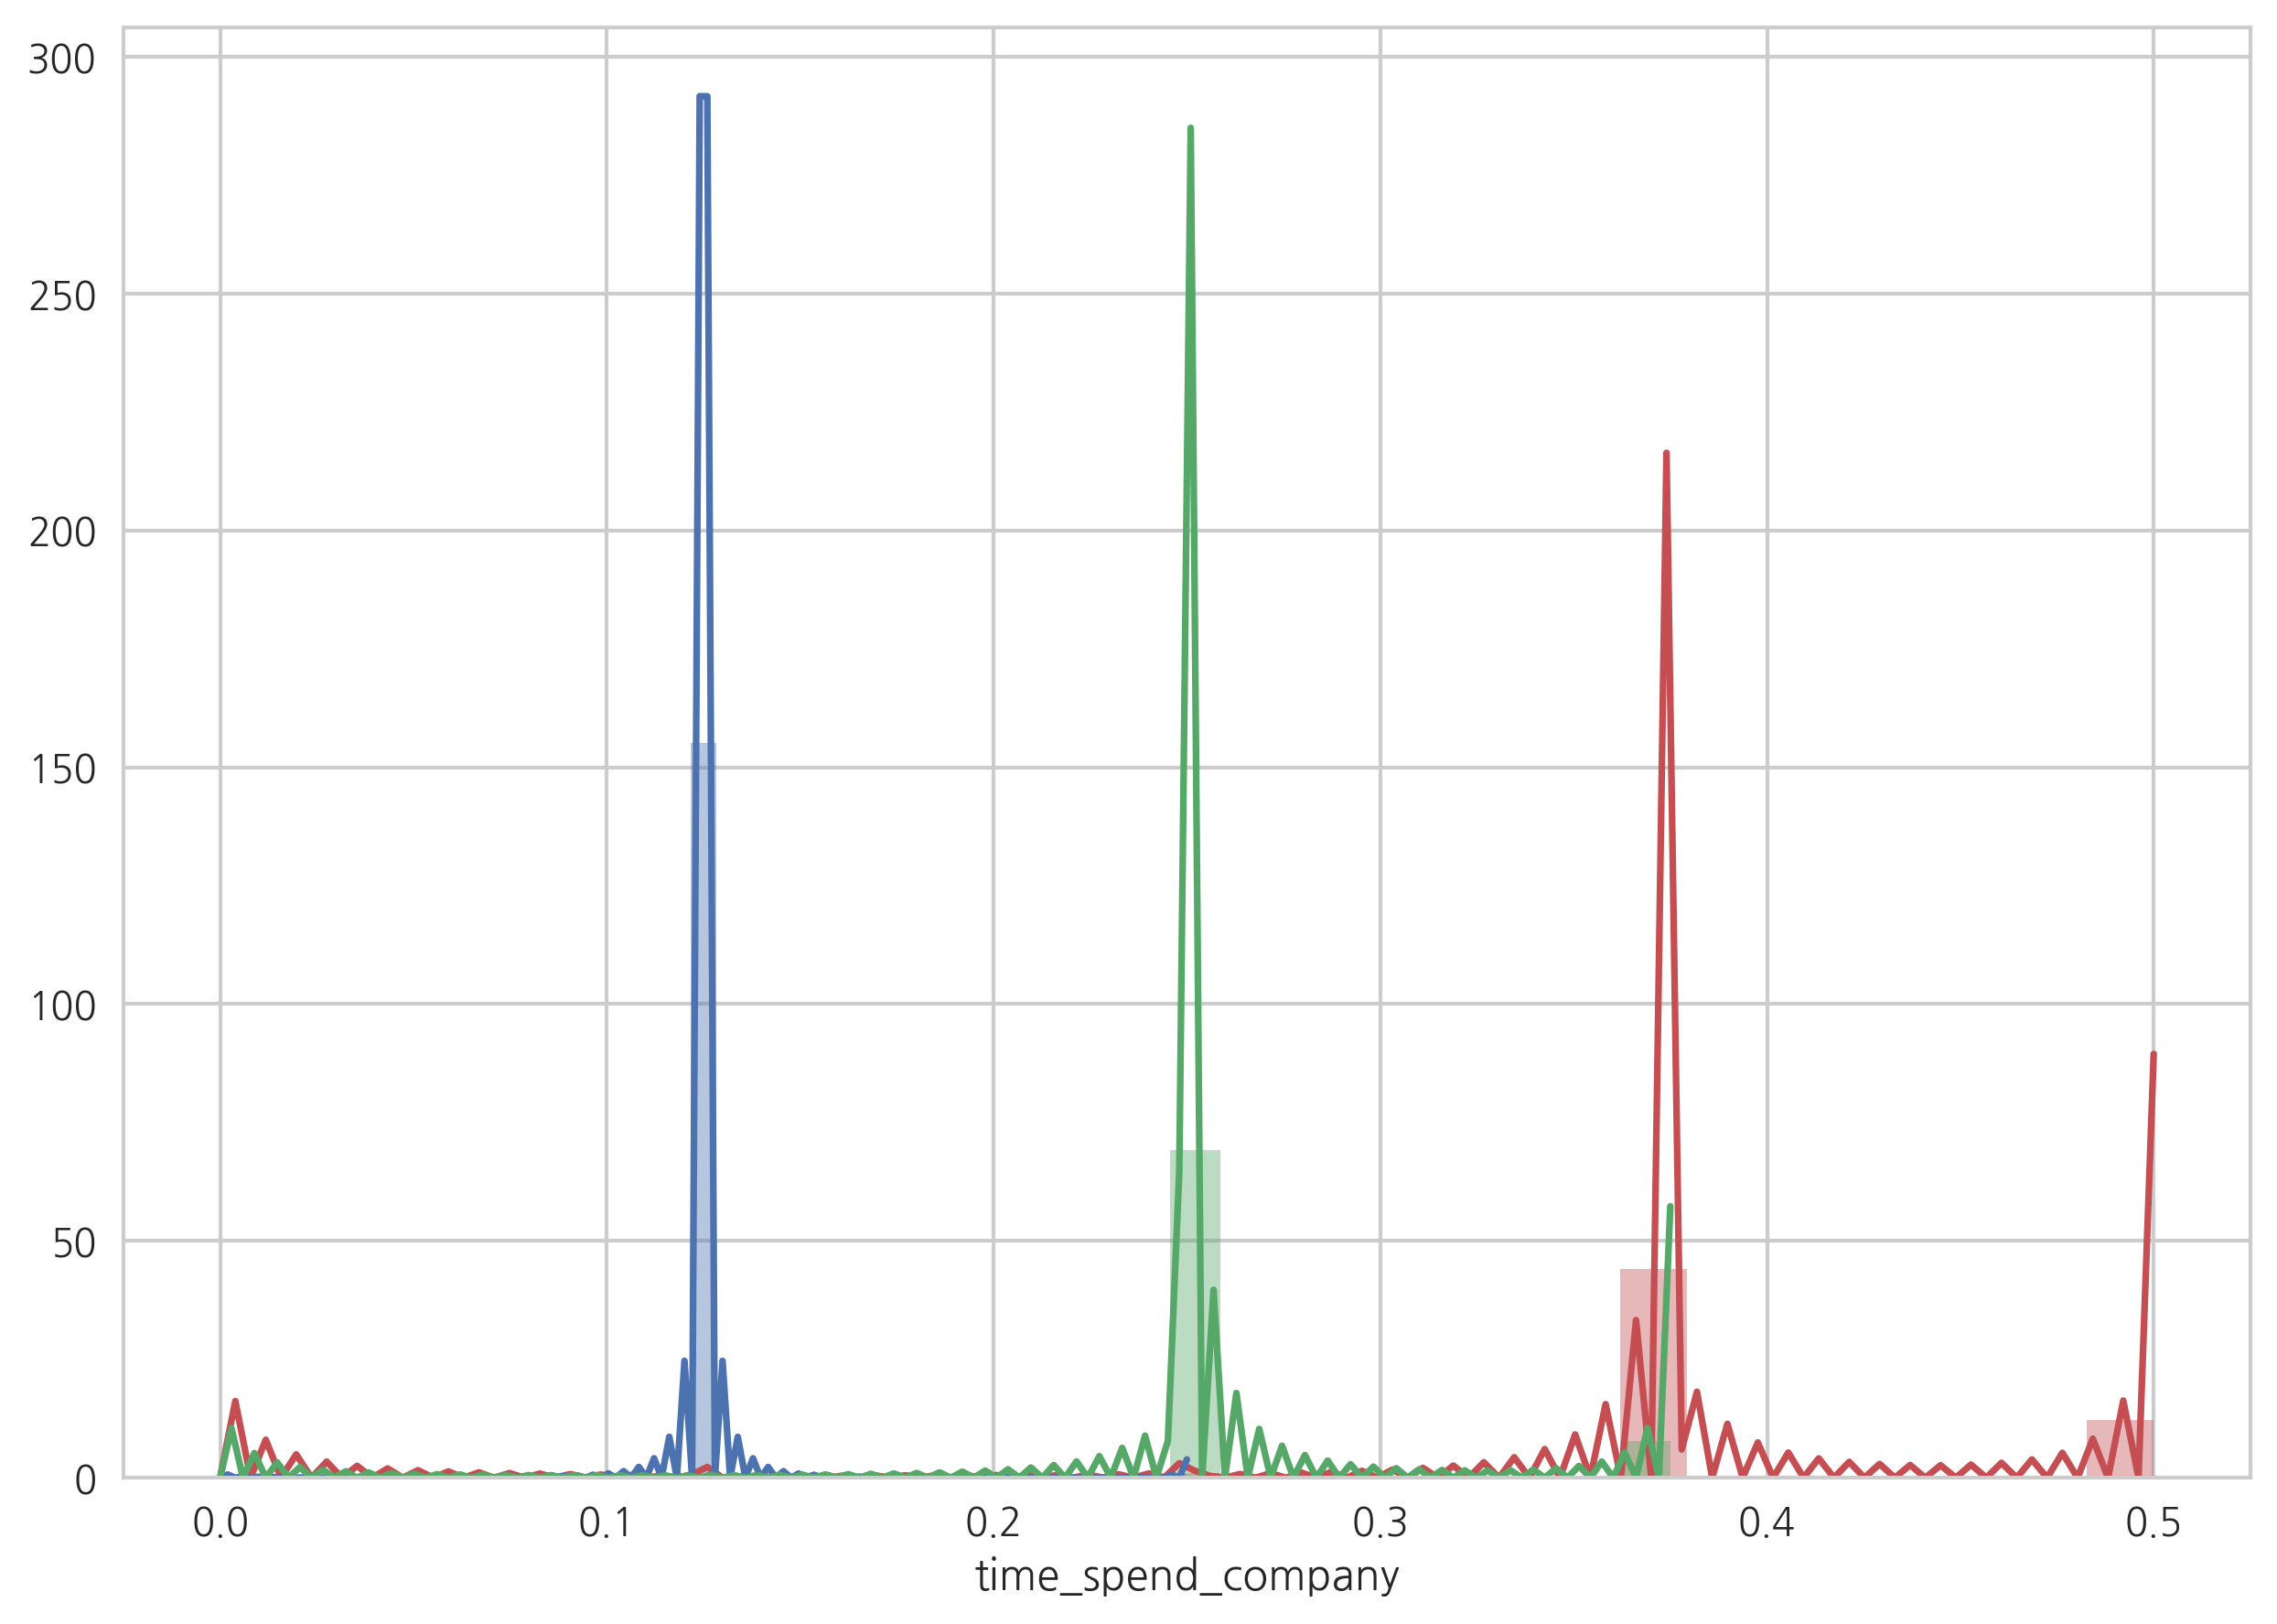

In [49]:
fig= plt.figure(num=1, figsize=(10,7))
ax = fig.add_subplot(111) 
ax.set_facecolor('white')

sns.distplot(df_cluster_1["time_spend_company"],color = 'r')
sns.distplot(df_cluster_2["time_spend_company"],color = 'b')
sns.distplot(df_cluster_3["time_spend_company"],color = 'g')
plt.show()

### radar chart

In [152]:
# 출처 : https://gist.github.com/sergiobuj/6721187


def _radar_factory(num_vars):
    theta = 2*np.pi * np.linspace(0, 1-1./num_vars, num_vars)
    theta += np.pi/2

    def unit_poly_verts(theta):
        x0, y0, r = [0.5] * 3
        verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
        return verts

    class RadarAxes(PolarAxes):
        name = 'radar'
        RESOLUTION = 1

        def fill(self, *args, **kwargs):
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(theta * 180/np.pi, labels)

        def _gen_axes_patch(self):
            verts = unit_poly_verts(theta)
            return plt.Polygon(verts, closed=True, edgecolor='k')

        def _gen_axes_spines(self):
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            verts.append(verts[0])
            path = Path(verts)
            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta

def radar_graph(labels = [], values = [],values_1 = [],values_2 = [],values_3 = [], optimum = []):
    
    params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
    pylab.rcParams.update(params)
    N = len(labels) 
    theta = _radar_factory(N)
    max_val = max(max(optimum), max(values))
    fig = plt.figure(num=1, figsize=(15,15))
    
    ax = fig.add_subplot(1, 1, 1, projection='radar')
    ax.set_facecolor('aliceblue')

    line1 = ax.plot(theta, values, color='r',ls="--",lw=2)
    line2 = ax.plot(theta, values_1, color='b',ls="--",lw=2)
    line3 = ax.plot(theta, values_2, color='g',ls="--",lw=2)
    line4 = ax.plot(theta, values_3, color='purple',ls="--",lw=2)
    
    ax.legend(['cluster_1',"cluster_2","cluster_3","remainder"],loc="right")
    ax.plot(theta, optimum, color='aliceblue',lw=1)
    ax.set_varlabels(labels)
   
    ax.set_title("# Cluster_per_score", weight='bold', position=(0.5, 1.13),
                     horizontalalignment='center', verticalalignment='center')
    
    plt.show()
    # plt.savefig("radar.png", dpi=100)

In [153]:
radar_1 =df_cluster_1[[u'satisfaction_level', u'last_evaluation', u'number_project',u'average_montly_hours', u'time_spend_company', u'promotion_last_5years',u'salary',u'Work_accident']].mean()
radar_2 =df_cluster_2[[u'satisfaction_level', u'last_evaluation', u'number_project',u'average_montly_hours', u'time_spend_company', u'promotion_last_5years',u'salary',u'Work_accident']].mean()
radar_3 =df_cluster_3[[u'satisfaction_level', u'last_evaluation', u'number_project',u'average_montly_hours', u'time_spend_company', u'promotion_last_5years',u'salary',u'Work_accident']].mean()
radar_4 = df_hr[[u'satisfaction_level', u'last_evaluation', u'number_project',u'average_montly_hours', u'time_spend_company', u'promotion_last_5years',u'salary',u'Work_accident']][df_hr.left==0].mean()

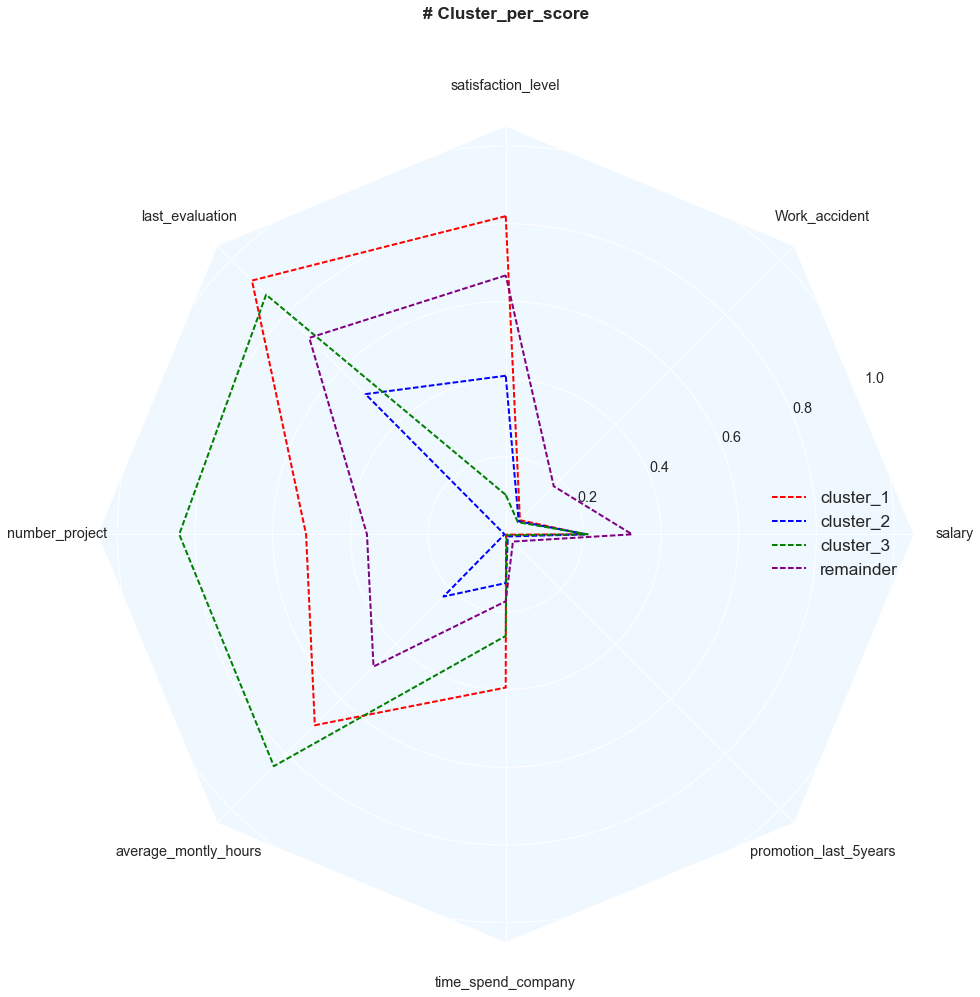

In [154]:
radar_graph(labels=radar_1.index,values=radar_1,values_1=radar_2,values_2=radar_3,values_3=radar_4,optimum=[1,1,1,1,1,1,1,1])

**radar chart**와 **distplot**등을 종합해보면, 

**cluster_1**의 경우에는 월 평균근로시간이 2번째로 크며, 프로젝트의 개수도 2번째이나 근속년수는 제일 컷으며,

**cluster_2**의 경우에는 월 평균근로시간 및 프로젝트의 개수 및 근속년수도 제일 작았다.

**cluster_3**의 경우에는 월 평균근로시간이 제일 크고, 프로젝트의 개수도 제일 많았으며, 근속년수는 2번째 였다.


이를 종합해보면
**cluster_1**의 경우에는 업무량등이 **적당한 편이어서 만족**하고 있는 편이나, 근속년수에 따른 **승진**이 안되고 있는 것에 불만인 것으로 원인을 찾을 수 있다.(cluster_1 890명 중에 5년간 승진인원은 1명이다.) 
**cluster_2**의 경우에는 **입사초기 인원**으로 적은 업무를 담당하고 있으나 업무에 대해 적응을 하지 못한 인원으로 볼 수 있다.(일명 **조기퇴사자**)
**cluster_3**의 경우에는 적당한 근속년수에도 불구하고 많은 일을 담당하고 있어 **과중한 업무량** 퇴사한 인원으로 볼 수 있다.(직무 불일치 등)


GE-9Block의 육성 및 방출 원칙을 근거로 해결책을 생각해보면, 
cluster_1의 문제를 예방하려면 직급을 세분화하거나 한 단계 더만들거나 역량급의 도입을 고려해볼 수 있으며(기존 3단계보다 좀 더 세분화된 임금체계가 필요하다. )

cluster_2의 문제는 굳이 해결할 필요가 없으나(조직의 환기를 위해서) 새로운 인력이 필요하다면, 조기 적응프로그램 도입 및 직무 순환 프로그램의 도입이 가능하다.
cluster_3의 문제는 업무량 조절 등이 필요한 상태이다.

이와 같은 **해결책**이 있다고 하더라도 **어떠한 인원들을 타케팅(targeting)**해서 도입해야되는지 알아보도록 하겠다.

<br />
<br />
<br />

# 4. Predict which valuable employees will leave next - cosine similarity

### 9block에 따라 labeling 해주기
![9-block.png](attachment:9-block.png)

In [62]:
df_hr["9-block"] = np.zeros(len(df_hr))

In [63]:
a = (df_hr.satisfaction_level >0) & (df_hr.satisfaction_level <=0.51) & (df_hr.last_evaluation>0) & (df_hr.last_evaluation<=0.6)
b = (df_hr.satisfaction_level >0) & (df_hr.satisfaction_level <=0.51) & (df_hr.last_evaluation>0.6) & (df_hr.last_evaluation<=0.82)
c = (df_hr.satisfaction_level >0) & (df_hr.satisfaction_level <=0.51) & (df_hr.last_evaluation>0.82) &(df_hr.last_evaluation<=1)
d = (df_hr.satisfaction_level >0.51)&(df_hr.satisfaction_level <=0.76)&(df_hr.last_evaluation>0)&(df_hr.last_evaluation<=0.6)
e = (df_hr.satisfaction_level >0.51)&(df_hr.satisfaction_level <=0.76)&(df_hr.last_evaluation>0.6)&(df_hr.last_evaluation<=0.82)
f = (df_hr.satisfaction_level >0.51)&(df_hr.satisfaction_level <=0.76)&(df_hr.last_evaluation>0.82)&(df_hr.last_evaluation<=1)
g = (df_hr.satisfaction_level >0.76)&(df_hr.satisfaction_level <=1)&(df_hr.last_evaluation>0)&(df_hr.last_evaluation<=0.6)
h = (df_hr.satisfaction_level >0.76)&(df_hr.satisfaction_level <=1)&(df_hr.last_evaluation>0.6)&(df_hr.last_evaluation<=0.82)
i = (df_hr.satisfaction_level >0.76)&(df_hr.satisfaction_level <=1)&(df_hr.last_evaluation>0.82)&(df_hr.last_evaluation<=1)

In [64]:
df_hr["9-block"][a] = 1
df_hr["9-block"][b] = 4
df_hr["9-block"][c] = 7
df_hr["9-block"][d] = 2
df_hr["9-block"][e] = 5
df_hr["9-block"][f] = 8
df_hr["9-block"][g] = 3
df_hr["9-block"][h] = 6
df_hr["9-block"][i] = 9

C:\Users\hapro\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\hapro\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\hapro\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\hapro\Anaconda2\lib\site-packages\ipykernel\__m

In [65]:
df_hr["9-block"].value_counts()

1.0    2473
5.0    2035
9.0    1990
6.0    1800
8.0    1685
2.0    1346
7.0    1322
4.0    1204
3.0    1144
Name: 9-block, dtype: int64

### 유사도 구해주기(cluster_1의 경우를 예로 들어서)
- cluster_1의 경우로 이동가능한 인원들은 **9-block에서 6,8,9**에 속한 인원들이다.
- 또한 해당 유사도를 더 세분화해주기 위해서 **sales와 salary**별로 구분해서 구해주도록 하겠다.

In [67]:
df_689 = df_hr[(df_hr["9-block"] ==9)|(df_hr["9-block"] ==8)|(df_hr["9-block"] ==6)][df_hr["left"] ==0]
del df_689["left"]

C:\Users\hapro\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [68]:
df_cluster_1_mean = df_cluster_1.groupby(["sales","salary"]).mean()

In [71]:
alpha =pd.merge(df_689,df_cluster_1_mean,left_on=["sales","salary"],right_index=True,how="inner")

In [169]:
alpha.head()

satisfaction_level_x  last_evaluation_x  number_project_x  \
126                  0.89               0.81               0.4   
129                  0.89               0.66               0.4   
130                  0.80               0.67               0.2   
131                  0.95               0.87               0.2   
135                  0.56               0.85               0.2   

     average_montly_hours_x  time_spend_company_x  Work_accident_x  \
126                0.616822                 0.250              0.0   
129                0.649533                 0.125              0.0   
130                0.317757                 0.125              0.0   
131                0.523364                 0.000              0.0   
135                0.602804                 0.125              0.0   

     promotion_last_5years_x sales  salary  9-block  satisfaction_level_y  \
126                      0.0    IT     1.0      6.0                 0.735   
129                      0.0    IT     1.0      6.0                 0.735   
130                      0.0    IT     1.0      6.0                 0.735   
131                      0.0    IT     1.0      9.0                 0.735   
135                      0.0    IT     1.0      8.0                 0.735   

     last_evaluation_y  number_project_y  average_montly_hours_y  \
126              0.935               0.6                 0.78271   
129              0.935               0.6                 0.78271   
130              0.935               0.6                 0.78271   
131              0.935               0.6                 0.78271   
135              0.935               0.6                 0.78271   

     time_spend_company_y  Work_accident_y  left  promotion_last_5years_y  \
126                 0.375              0.0     1                      0.0   
129                 0.375              0.0     1                      0.0   
130                 0.375              0.0     1                      0.0   
131                 0.375              0.0     1                      0.0   
135                 0.375              0.0     1                      0.0   

     similarity  
126    0.828278  
129    0.814397  
130    0.777643  
131    0.773699  
135    0.814357

### 코사인 유사도로 해준 이유는?
- 유사도를 구하는 방식은 유클리디안 점수기반 알고리즘, 코사인 기반, 자카드 계수, 피어슨 상관계수 등 다양한 종류가 있다.
- 하지만 코사인 유사도로 해준 이유는 **방향성**으로 유사도를 측정하기 때문이다.
- 즉 프로젝트의 개수, 월 평균 근로시간, 근속년수 등이 퇴직자와 비슷한 비율로 나타난다면 이 인원이 퇴직할 가능성이 높다고 생각하였다.

In [72]:
alpha_similarity = np.zeros(len(alpha))

for i in range(len(alpha)):
    distance = cosine_similarity(alpha.iloc[i,[0,1,2,3,4,5,6]],alpha.iloc[i,[10,11,12,13,14,15,16]])
    alpha_similarity[i] = distance.flatten()
    
alpha["similarity"] = alpha_similarity

C:\Users\hapro\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\hapro\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\hapro\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarn

### 9-block에서 6,8,9에 속하는 인원의 분포

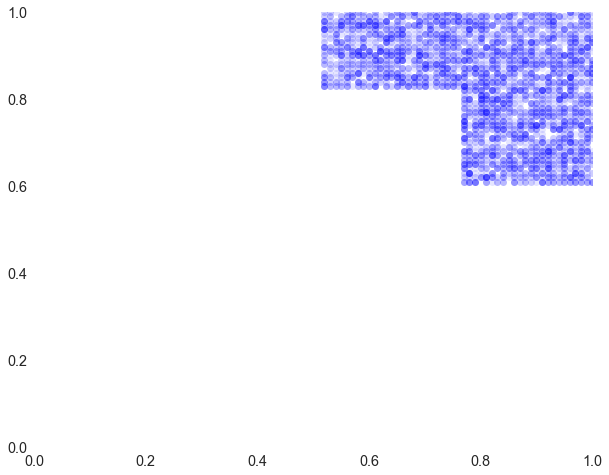

In [85]:
fig= plt.figure(num=1, figsize=(10,8))
ax = fig.add_subplot(111) 
ax.set_facecolor('white')

plt.plot(df_689.satisfaction_level,df_689.last_evaluation,'o', alpha = 0.1,c="blue")
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

### 코사인 유사도가 85% 이상인 인원의 분포

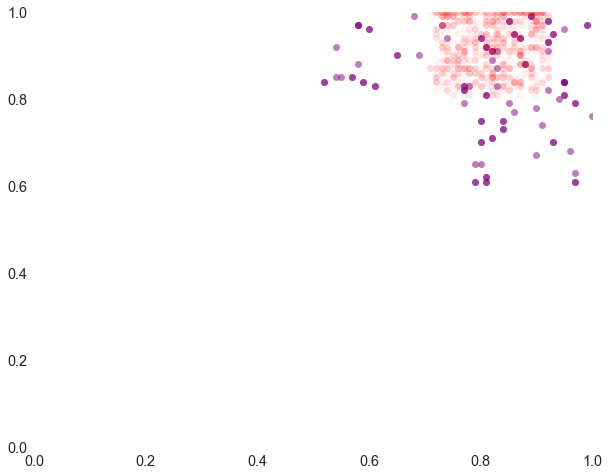

In [108]:
fig= plt.figure(num=1, figsize=(10,8))
ax = fig.add_subplot(111) 
ax.set_facecolor('white')

plt.plot(alpha.satisfaction_level_x[alpha.similarity >0.85],alpha.last_evaluation_x[alpha.similarity >0.85],'o', alpha = 0.5, c="purple")
plt.plot(df_cluster_1.satisfaction_level,df_cluster_1.last_evaluation,'o', alpha = 0.05,color = "r")
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

즉 위와 같이 해당 클러스터와 유사도를 기준으로 인원을 뽑아낸다음에 이들을 타케팅해서 이직 방지의 program을 운영할 수 있다.

<br />
<br />
<br />

# 5. 결론 및 추가 논의사항

### 결론

- 데이터를 **countplot**등으로 전반적인 상황을 살펴본 뒤에,

- 퇴사자와 잔류자를 구분하여 **pairplot**으로 cluster의 형태를 살폈다.

- 그룹핑 시킬때는 GE-9block을 이용해서 구분해주었으며 cluster내의 특징으로 각 **클러스터별 문제점**을 PCA 등으로 진단 및 해결책을 제시하였다.

- 어떤 인원이 퇴사할지에 대해서는 classification이 적용가능한 머신러닝(딥러닝) 이론을 적용하기보다는 **cosine 유사도**로 찾아내었다.

### 추가 논의사항

- kaggle에 있는 많은 사람들이 classification으로 예측을 하였는데, 어떤 것을 예측하였는지 이해하기 힘들었다. 
- 이 부분에 대해서는 classification 등을 다시 공부하고 무엇이 옳은것인지 판단해야될 부분이다.